# Experiments: TensorFlow Lite applications analysis for both with and without HTTP handling implementation

This notebook allows to run every experiments used to analyze the capabilities of the two implmentations of the TensorFlow Lite application, i.e. with and without HTTP handling capability.

In [99]:
# Imports
import os
import re
import sys
import ast
import time
import pathlib
import datetime
import itertools
import textwrap
import numpy as np
import subprocess
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [100]:
# Global variables

# Paths
global_res_dir = "./results"
assets_path="./assets"


In [101]:
# ssh and scp functions with arguements
ssh_with_args = "ssh -o UserKnownHostsFile=/dev/null -o StrictHostKeyChecking=no"
scp_with_args = "scp -o UserKnownHostsFile=/dev/null -o StrictHostKeyChecking=no"

## Experiment 1: Analysis of the execution time of each important part of the TensorFlow Lite application for classical setup

In [149]:
# Experiment setup
experiment_name = "Execution time by part"
timestamp = timestamp=datetime.datetime.now() # Current timestamp

iteration = 20
ssh_info = "pptc@192.168.88.3"
ssh_ip = "192.168.88.3"
implementations = ["label_image", "label_image_with_crow"]
mediums = ["WiFi 2.4GHz 20-40MHz", "WiFi 5.0GHz 20-40-80MHz", "Ethernet"]
count_for_usage_script = 30 # correspond to the number of measure taken (1 per second)

### Perform experiment

In [114]:
# Experiment path
exp_folder_name = experiment_name.replace(' ', '_') + "_" + timestamp.strftime("%Y%m%dT%H%M%S")
exp_folder_name = experiment_name.replace(' ', '_') + "_Final"
curr_exp_dir = global_res_dir + "/" + exp_folder_name

# Remote path
remote_exp_results_dir = "~/" + exp_folder_name + "/results"
remote_exp_cpu_usage_dir = remote_exp_results_dir + "/cpu_usage"
remote_exp_ram_usage_dir = remote_exp_results_dir + "/ram_usage"
remote_exp_scripts_dir = "~/" + exp_folder_name + "/scripts"

# Copy scripts on remote device
!{ssh_with_args} {ssh_info} "mkdir -p ~/{exp_folder_name}"
!{scp_with_args} -r scripts/ {ssh_info}:~/{exp_folder_name}

# Perform the experiment
for imp in implementations:
    imp_mediums = ["na"] if imp == "label_image" else mediums

    # Copy needed assets (executable and images)
    print(f"Copy assets for {imp} on remote device")
    !{scp_with_args} -r {assets_path}/{imp} {ssh_info}:~/{exp_folder_name}/{imp}

    for med in imp_mediums:
        # Validate config:
        print(f"Prepare next config:\n\tImplementation: {imp}\n\tMedium: {med}\n\t\n")
        time.sleep(2)
        v = input("Press ENTER to run the benchmark")
        print(f"Value : {v}")
        if v == "s": # stop
            break
        print("Run benchmark...")

        # Create remote workspace
        !{ssh_with_args} {ssh_info} "mkdir -p {remote_exp_cpu_usage_dir}; mkdir -p {remote_exp_ram_usage_dir}"

        # Implementation paths
        curr_exp_imp_dir = curr_exp_dir + "/" + imp.replace(' ', '_')
        curr_exp_imp_med_dir = curr_exp_imp_dir + ("/" + med.replace(' ', '_') if med != "na" else "")
        curr_exp_imp_raw_dir = curr_exp_imp_med_dir + "/raw_results"
        curr_exp_imp_raw_file = curr_exp_imp_raw_dir + "/execution_time_by_part.txt"
        curr_exp_imp_res_dir = curr_exp_imp_med_dir + "/results"

        # Remote paths
        cpu_usage_remote_file = remote_exp_cpu_usage_dir + "/results_cpu_usage_" + imp + "_" + med.replace(' ', '_') + ".txt"
        ram_usage_remote_file = remote_exp_ram_usage_dir + "/results_ram_usage_" + imp + "_" + med.replace(' ', '_') + ".txt"

        # Create results dir
        path = Path(curr_exp_dir)
        path.mkdir(parents=True, exist_ok=True)
        path = Path(curr_exp_imp_dir)
        path.mkdir(parents=True, exist_ok=True)
        path = Path(curr_exp_imp_raw_dir)
        path.mkdir(parents=True, exist_ok=True)
        path = Path(curr_exp_imp_res_dir)
        path.mkdir(parents=True, exist_ok=True)

        # Print experiment setup in results file
        # Local for execution time
        with open(curr_exp_imp_raw_file, "w") as raw:
            raw.write(f"# SSH_INFO={ssh_info}\n")
            raw.write(f"# ITERATIONS={iteration}\n")
            raw.write(f"# IMPLEMENTATION={imp}\n")
            raw.write(f"# MEDIUM={med}\n")

        # Remote for cpu and ram usage
        !{ssh_with_args} {ssh_info} "echo -e \"# SSH_INFO={ssh_info}\n# ITERATIONS={iteration}\n# IMPLEMENTATION={imp}\n# MEDIUM={med}\n# COUNT={count_for_usage_script}\n\" > {cpu_usage_remote_file}"
        !{ssh_with_args} {ssh_info} "echo -e \"# SSH_INFO={ssh_info}\n# ITERATIONS={iteration}\n# IMPLEMENTATION={imp}\n# MEDIUM={med}\n# COUNT={count_for_usage_script}\n\" > {ram_usage_remote_file}"

        # Perform test
        for i in range(iteration):
            # Print iteration
            print(f"Iteration {i}")
            with open(curr_exp_imp_raw_file, "a") as raw:
                raw.write(f"\n# ITERATION {i}\n")
            !{ssh_with_args} {ssh_info} "echo -e \"\n# ITERATION {i}\n\" >> {cpu_usage_remote_file}"
            !{ssh_with_args} {ssh_info} "echo -e \"\n# ITERATION {i}\n\" >> {ram_usage_remote_file}"

            # Run cpu and ram usage script
            print("Start CPU and RAM usage scripts")
            
            cpu_usage_process = subprocess.Popen(f'{ssh_with_args} {ssh_info} "{remote_exp_scripts_dir}/cpu_usage_script.sh {count_for_usage_script} {cpu_usage_remote_file} 0"', shell=True)
            ram_usage_process = subprocess.Popen(f'{ssh_with_args} {ssh_info} "{remote_exp_scripts_dir}/ram_usage_script.sh {count_for_usage_script} {ram_usage_remote_file} 0"', shell=True)

            print("Sleep 3s")
            time.sleep(3) # To have more usage measures

            
            print("Perform measure")
            if imp == "label_image":
                start_timestamp = int(datetime.datetime.now().timestamp()) # Timestamp at which the inference request started
                !{ssh_with_args} {ssh_info} "cd ~/{exp_folder_name}/{imp}; (time ./{imp} -m mobilenet_v1_1.0_224.tflite -l labels.txt -i grace_hopper.bmp -t 1 -d 1 -w 0)" &>> {curr_exp_imp_raw_file}

                stop_timestamp = int(datetime.datetime.now().timestamp()) # Timestamp at which the inference request started
            else:
                server_process = subprocess.Popen(f'{ssh_with_args} {ssh_info} "cd ~/{exp_folder_name}/{imp}; ./{imp} -c config.json"', shell=True)
                time.sleep(3)
                
                start_timestamp = int(datetime.datetime.now().timestamp()) # Timestamp at which the inference request started
                !(time curl -X POST -F "image=@{assets_path}/label_image_with_crow/grace_hopper.bmp" http://{ssh_ip}:18080/label_image) &>> {curr_exp_imp_raw_file}

                stop_timestamp = int(datetime.datetime.now().timestamp()) # Timestamp at which the inference request started
                
                # Kill server
                print("Kill server")
                server_process.kill()
                !{ssh_with_args} {ssh_info} 'kill $(pidof {imp})'


            print("Sleep 3s")
            time.sleep(3)  # To have more usage measures

            print("Kill CPU and RAM usage scripts")
            cpu_usage_process.kill()
            ram_usage_process.kill()
            !{ssh_with_args} {ssh_info} 'kill $(pidof cpu_usage_script.sh)'
            !{ssh_with_args} {ssh_info} 'kill $(pidof ram_usage_script.sh)'

            !{ssh_with_args} {ssh_info} "echo \"# TIMESTAMP_START={start_timestamp}\" >> {cpu_usage_remote_file}; echo \"# TIMESTAMP_STOP={stop_timestamp}\" >> {cpu_usage_remote_file}"
            !{ssh_with_args} {ssh_info} "echo \"# TIMESTAMP_START={start_timestamp}\" >> {ram_usage_remote_file}; echo \"# TIMESTAMP_STOP={stop_timestamp}\" >> {ram_usage_remote_file}"

        print("Retrieve usage results and remove remote workspace")
        !{scp_with_args} -r {ssh_info}:{remote_exp_cpu_usage_dir} {curr_exp_imp_raw_dir}
        !{scp_with_args} -r {ssh_info}:{remote_exp_ram_usage_dir} {curr_exp_imp_raw_dir}

        !{ssh_with_args} {ssh_info} "rm -rf {remote_exp_cpu_usage_dir}; rm -rf {remote_exp_ram_usage_dir}"

# Remove remote workspace
!{ssh_with_args} {ssh_info} "rm -rf ~/{exp_folder_name}"

cpu_usage_script.sh                           100% 1189   666.5KB/s   00:00    
ram_usage_script.sh                           100% 1253   816.5KB/s   00:00    
Copy assets for label_image on remote device
label_image                                   100% 4996KB  11.1MB/s   00:00    
mobilenet_v1_1.0_224.tflite                   100%   16MB   3.4MB/s   00:04    
grace_hopper.bmp                              100%  919KB  10.7MB/s   00:00    
labels.txt                                    100%   10KB   3.0MB/s   00:00    
Prepare next config:
	Implementation: label_image
	Medium: na
	

Value : 
Run benchmark...
Iteration 0
Start CPU and RAM usage scripts
Sleep 3s


Perform measure
Sleep 3s
Kill CPU and RAM usage scripts
Iteration 1
Start CPU and RAM usage scripts
Sleep 3s


Perform measure
Sleep 3s
Kill CPU and RAM usage scripts
Iteration 2
Start CPU and RAM usage scripts
Sleep 3s


Perform measure
Sleep 3s
Kill CPU and RAM usage scripts
Iteration 3
Start CPU and RAM usage scripts
Sleep 3s


Perform measure
Sleep 3s
Kill CPU and RAM usage scripts
Iteration 4
Start CPU and RAM usage scripts
Sleep 3s


Perform measure
Sleep 3s
Kill CPU and RAM usage scripts
Iteration 5
Start CPU and RAM usage scripts
Sleep 3s


Perform measure
Sleep 3s
Kill CPU and RAM usage scripts
Iteration 6
Start CPU and RAM usage scripts
Sleep 3s


Perform measure
Sleep 3s
Kill CPU and RAM usage scripts
Iteration 7
Start CPU and RAM usage scripts
Sleep 3s


Perform measure
Sleep 3s
Kill CPU and RAM usage scripts
Iteration 8
Start CPU and RAM usage scripts
Sleep 3s


Perform measure
Sleep 3s
Kill CPU and RAM usage scripts
Iteration 9
Start CPU and RAM usage scripts
Sleep 3s


Perform measure
Sleep 3s
Kill CPU and RAM usage scripts
Iteration 10
Start CPU and RAM usage scripts
Sleep 3s


Perform measure
Sleep 3s
Kill CPU and RAM usage scripts
Iteration 11
Start CPU and RAM usage scripts
Sleep 3s


Perform measure
Sleep 3s
Kill CPU and RAM usage scripts
Iteration 12
Start CPU and RAM usage scripts
Sleep 3s


Perform measure
Sleep 3s
Kill CPU and RAM usage scripts
Iteration 13
Start CPU and RAM usage scripts
Sleep 3s


Perform measure
Sleep 3s
Kill CPU and RAM usage scripts
Iteration 14
Start CPU and RAM usage scripts
Sleep 3s


Perform measure
Sleep 3s
Kill CPU and RAM usage scripts
Iteration 15
Start CPU and RAM usage scripts
Sleep 3s


Perform measure
Sleep 3s
Kill CPU and RAM usage scripts
Iteration 16
Start CPU and RAM usage scripts
Sleep 3s


Perform measure
Sleep 3s
Kill CPU and RAM usage scripts
Iteration 17
Start CPU and RAM usage scripts
Sleep 3s


Perform measure
Sleep 3s
Kill CPU and RAM usage scripts
Iteration 18
Start CPU and RAM usage scripts
Sleep 3s


Perform measure
Sleep 3s
Kill CPU and RAM usage scripts
Iteration 19
Start CPU and RAM usage scripts
Sleep 3s


Perform measure
Sleep 3s
Kill CPU and RAM usage scripts
Retrieve usage results and remove remote workspace
results_cpu_usage_label_image_na.txt          100% 8571     2.9MB/s   00:00    
results_ram_usage_label_image_na.txt          100%   10KB   2.6MB/s   00:00    


### Process results

In [150]:
def process_part_execution_time_raw_results_to_dataframe(raw_results_path):
    df = pd.DataFrame()
    medium=""
    implementation=""

    parts = []
    subparts = []
    values = []
    iterations = []

    with open(raw_results_path, "r") as raw:
        for line in raw:
            if line.startswith("# MEDIUM="):
                medium = line.split('=')[1].strip()
            elif line.startswith("# IMPLEMENTATION="):
                implementation = line.split('=')[1].strip()
            elif line.startswith("# ITERATION "):
                iterations.append(int(line.split(' ')[2].strip()))
            elif line.startswith("TIME: "):
                _, part, subpart, value = line.split(':')
                value = float(value.strip().split(' ')[0].strip())
                parts.append(part.strip())
                subparts.append(subpart.strip())
                values.append(value)
            elif line.startswith("real"):
                min_sec_ms = line.strip().split('\t')[1]
                min, sec_ms = min_sec_ms.split('m')
                min = int(min.strip())
                sec_ms = float(sec_ms.strip()[:-1])
                parts.append("Real time")
                subparts.append("Global time")
                values.append(((min * 60) + sec_ms) * 1000000)


    n_repeat = len(parts)//len(iterations)
    iterations = [iterations[i//n_repeat] for i in range(len(iterations) * n_repeat)]
    df["Iteration"] = iterations
    df["Part"] = parts
    df["Subpart"] = subparts
    df["Execution Time (in us)"] = values
    df["Medium"] = [medium] * df.shape[0]
    df["Implementation"] = [implementation] * df.shape[0]

    df["Part"] = df["Part"].replace("Crow", "Crow Webserver")

    return df

def process_cpu_usage_to_dataframe(raw_results_path):
    df = pd.DataFrame()
    medium=""
    implementation=""

    timestamp_values = []
    user_values = []
    nice_values = []
    system_values = []
    idle_values = []
    iowait_values = []
    irq_values = []
    softirq_values = []
    iteration_values = []
    timestamp_start_values = []
    timestamp_stop_values = []
    
    iteration_v = -1
    n_values_per_iter = 0

    with open(raw_results_path, "r") as raw:
        for line in raw:
            if line.startswith("# MEDIUM="):
                medium = line.split('=')[1].strip()
            elif line.startswith("# IMPLEMENTATION="):
                implementation = line.split('=')[1].strip()
            elif line.startswith("# ITERATION "):
                if iteration_v != -1:
                    iteration_values += [iteration_v] * n_values_per_iter
                iteration_v = int(line.split(' ')[2].strip())
                n_values_per_iter = 0
            elif not line.startswith("#") and line.strip(): # Also check not empty
                timestamp_v, user_v, nice_v, system_v, idle_v, iowait_v, irq_v, softirq_v = line.split(',')
                timestamp_values.append(int(timestamp_v.strip()))
                user_values.append(float(user_v.strip()))
                nice_values.append(float(nice_v.strip()))
                system_values.append(float(system_v.strip()))
                idle_values.append(float(idle_v.strip()))
                iowait_values.append(float(iowait_v.strip()))
                irq_values.append(float(irq_v.strip()))
                softirq_values.append(float(softirq_v.strip()))
                n_values_per_iter += 1
            elif line.startswith("# TIMESTAMP_START="):
                timestamp_start_values += [int(line.split('=')[1].strip())] * n_values_per_iter
            elif line.startswith("# TIMESTAMP_STOP="):
                timestamp_stop_values += [int(line.split('=')[1].strip())] * n_values_per_iter 
        iteration_values += [iteration_v] * n_values_per_iter # Last at end of file

    df["Iteration"] = iteration_values
    df["Timestamp"] = timestamp_values
    df["User"] = user_values
    df["Nice"] = nice_values
    df["System"] = system_values
    df["Idle"] = idle_values
    df["IOwait"] = iowait_values
    df["IRQ"] = irq_values
    df["SoftIRQ"] = softirq_values
    df["Timestamp Start"] = timestamp_start_values
    df["Timestamp Stop"] = timestamp_stop_values
    df["Medium"] = [medium] * df.shape[0]
    df["Implementation"] = [implementation] * df.shape[0]


    # Compute CPU usage and Timestamp from 0
    df['Total'] = df[["User", "Nice", "System", "Idle", "IOwait", "IRQ", "SoftIRQ"]].sum(axis=1)
    
    groups = []

    for _, group in df.groupby(["Iteration"]):
        group["Indexes"] = group.index
        group = group.reset_index()
        init_timestamp = group.loc[0, "Timestamp"]
        group["Timestamp Sliced"] = group["Timestamp"] - init_timestamp
        group["Timestamp Start Sliced"] = group["Timestamp Start"] - init_timestamp
        group["Timestamp Stop Sliced"] = group["Timestamp Stop"] - init_timestamp
        group["Has Workload"] = (group["Timestamp Start"] <= group["Timestamp"]) & (group["Timestamp"] <= group["Timestamp Stop"])

        group['Last Idle'] = group['Idle'].shift(1).fillna(0)
        group['Last Total'] = group['Total'].shift(1).fillna(0)
        group['Idle Delta'] = group['Idle'] - group['Last Idle']
        group['Total Delta'] = group['Total'] - group['Last Total']
        group['Usage'] = 100.0 * (1.0 - (group['Idle Delta'] / group['Total Delta']))

        group = group.set_index("Indexes")

        groups.append(group)

    df_usage = pd.concat(groups)
    df["Usage"] = df_usage["Usage"]
    df["Timestamp Sliced"] = df_usage["Timestamp Sliced"]
    df["Timestamp Start Sliced"] = df_usage["Timestamp Start Sliced"]
    df["Timestamp Stop Sliced"] = df_usage["Timestamp Stop Sliced"]
    df["Has Workload"] = df_usage["Has Workload"]

    return df.drop(["Total"], axis="columns")


def process_ram_usage_to_dataframe(raw_results_path):
    df = pd.DataFrame()
    medium=""
    implementation=""

    timestamp_values = []
    memtotal_values = []
    memfree_values = []
    memavailable_values = []
    cache_values = []
    buffer_values = []
    swaptotal_values = []
    swapfree_values = []
    swapcached_values = []
    iteration_values = []
    timestamp_start_values = []
    timestamp_stop_values = []
    
    iteration_v = -1
    n_values_per_iter = 0

    with open(raw_results_path, "r") as raw:
        for line in raw:
            if line.startswith("# MEDIUM="):
                medium = line.split('=')[1].strip()
            elif line.startswith("# IMPLEMENTATION="):
                implementation = line.split('=')[1].strip()
            elif line.startswith("# ITERATION "):
                if iteration_v != -1:
                    iteration_values += [iteration_v] * n_values_per_iter
                iteration_v = int(line.split(' ')[2].strip())
                n_values_per_iter = 0
            elif not line.startswith("#") and line.strip(): # Also check not empty
                timestamp_v, memtotal_v, memfree_v, memavailable_v, cache_v, buffer_v, swaptotal_v, swapfree_v, swapcached_v = line.split(',')
                timestamp_values.append(int(timestamp_v.strip()))
                memtotal_values.append(float(memtotal_v.strip()))
                memfree_values.append(float(memfree_v.strip()))
                memavailable_values.append(float(memavailable_v.strip()))
                cache_values.append(float(cache_v.strip()))
                buffer_values.append(float(buffer_v.strip()))
                swaptotal_values.append(float(swaptotal_v.strip()))
                swapfree_values.append(float(swapfree_v.strip()))
                swapcached_values.append(float(swapcached_v.strip()))
                n_values_per_iter += 1
            elif line.startswith("# TIMESTAMP_START="):
                timestamp_start_values += [int(line.split('=')[1].strip())] * n_values_per_iter
            elif line.startswith("# TIMESTAMP_STOP="):
                timestamp_stop_values += [int(line.split('=')[1].strip())] * n_values_per_iter 
        iteration_values += [iteration_v] * n_values_per_iter # Last at end of file

    df["Iteration"] = iteration_values
    df["Timestamp"] = timestamp_values
    df["Total Memory"] = memtotal_values
    df["Free Memory"] = memfree_values
    df["Available Memory"] = memavailable_values
    df["Cache"] = cache_values
    df["Buffer"] = buffer_values
    df["Total Swap"] = swaptotal_values
    df["Free Swap"] = swapfree_values
    df["Cached Swap"] = swapcached_values
    df["Timestamp Start"] = timestamp_start_values
    df["Timestamp Stop"] = timestamp_stop_values
    df["Medium"] = [medium] * df.shape[0]
    df["Implementation"] = [implementation] * df.shape[0]


    # Compute RAM usage and Timestamp from 0
    groups = []

    for _, group in df.groupby(["Iteration"]):
        group["Indexes"] = group.index
        group = group.reset_index()
        init_timestamp = group.loc[0, "Timestamp"]
        group["Timestamp Sliced"] = group["Timestamp"] - init_timestamp
        group["Timestamp Start Sliced"] = group["Timestamp Start"] - init_timestamp
        group["Timestamp Stop Sliced"] = group["Timestamp Stop"] - init_timestamp
        group["Has Workload"] = (group["Timestamp Start"] <= group["Timestamp"]) & (group["Timestamp"] <= group["Timestamp Stop"])
        group["Usage"] = (1 - (group["Free Memory"]/group["Total Memory"])) * 100.0

        group = group.set_index("Indexes")

        groups.append(group)

    df_usage = pd.concat(groups)
    df["Usage"] = df_usage["Usage"]
    df["Timestamp Sliced"] = df_usage["Timestamp Sliced"]
    df["Timestamp Start Sliced"] = df_usage["Timestamp Start Sliced"]
    df["Timestamp Stop Sliced"] = df_usage["Timestamp Stop Sliced"]
    df["Has Workload"] = df_usage["Has Workload"]

    return df


In [151]:
exp_dir = global_res_dir + "/" + experiment_name.replace(' ', '_') + "_" + timestamp.strftime("%Y%m%dT%H%M%S")
exp_dir = global_res_dir + "/" + experiment_name.replace(' ', '_') + "_Final"

df_execution_time_by_part = []
df_cpu_usages = []
df_ram_usages= []

for imp in implementations:
    exp_imp_dir = exp_dir + "/" + imp
    imp_mediums = ["na"] if imp == "label_image" else mediums
    for med in imp_mediums:
        exp_imp_med_dir = exp_imp_dir + (("/" + med.replace(' ', '_')) if imp != "label_image" else "")
        exp_imp_med_raw_dir = exp_imp_med_dir + "/raw_results"
        exp_cpu_imp_med_raw_dir = exp_imp_med_raw_dir + "/cpu_usage"
        exp_ram_imp_med_raw_dir = exp_imp_med_raw_dir + "/ram_usage"
        exp_imp_med_res_dir = exp_imp_med_dir + "/results"

        path = Path(exp_imp_med_res_dir)
        path.mkdir(parents=True, exist_ok=True)

        # Execution time by part
        df_execution_time_by_part_imp_med = process_part_execution_time_raw_results_to_dataframe(exp_imp_med_raw_dir + "/execution_time_by_part.txt")
        df_execution_time_by_part.append(df_execution_time_by_part_imp_med)
        df_execution_time_by_part_imp_med.to_csv(exp_imp_med_res_dir + "/execution_time_by_parts_" + imp + (("_" + med) if imp != "label_image" else "") + ".csv", index=False)

        # CPU usage
        df_cpu_usages_med = []
        for file in os.listdir(exp_cpu_imp_med_raw_dir):
            df_cpu_usages_med.append(process_cpu_usage_to_dataframe(exp_cpu_imp_med_raw_dir + "/" + file))
        df_cpu_usages_med = pd.concat(df_cpu_usages_med, ignore_index=True)
        df_cpu_usages.append(df_cpu_usages_med)
        df_cpu_usages_med.to_csv(exp_imp_med_res_dir + "/cpu_usage_" + imp + (("_" + med) if imp != "label_image" else "") + ".csv", index=False)


        # RAM usage
        df_ram_usages_med = []
        for file in os.listdir(exp_ram_imp_med_raw_dir):
            df_ram_usages_med.append(process_ram_usage_to_dataframe(exp_ram_imp_med_raw_dir + "/" + file))
        df_ram_usages_med = pd.concat(df_ram_usages_med, ignore_index=True)
        df_ram_usages.append(df_ram_usages_med)
        df_cpu_usages_med.to_csv(exp_imp_med_res_dir + "/ram_usage_" + imp + (("_" + med) if imp != "label_image" else "") + ".csv", index=False)

# Execution time by part
df_execution_time_by_part = pd.concat(df_execution_time_by_part, ignore_index=True)
df_execution_time_by_part.to_csv(exp_dir + "/execution_time_by_parts.csv", index=False)

# CPU usage
df_cpu_usages = pd.concat(df_cpu_usages, ignore_index=True)
df_cpu_usages.to_csv(exp_dir + "/cpu_usage.csv", index=False)

# RAM usage
df_ram_usages = pd.concat(df_ram_usages, ignore_index=True)
df_ram_usages.to_csv(exp_dir + "/ram_usage.csv", index=False)

# display(df_execution_time_by_part)
# display(df_cpu_usages)
# display(df_ram_usages)

### Make Graphs

In [152]:
# Global variables
exp_dir = global_res_dir + "/" + experiment_name.replace(' ', '_') + "_" + timestamp.strftime("%Y%m%dT%H%M%S")
exp_dir = global_res_dir + "/" + experiment_name.replace(' ', '_') + "_Final"

graphs_dir = exp_dir + "/graphs"
graphs_exec_time_dir = graphs_dir + "/execution_time_by_part"
graphs_cpu_usage_dir = graphs_dir + "/cpu_usage"
graphs_ram_usage_dir = graphs_dir + "/ram_usage"

path = Path(graphs_dir)
path.mkdir(parents=True, exist_ok=True)
path = Path(graphs_exec_time_dir)
path.mkdir(parents=True, exist_ok=True)
path = Path(graphs_cpu_usage_dir)
path.mkdir(parents=True, exist_ok=True)
path = Path(graphs_ram_usage_dir)
path.mkdir(parents=True, exist_ok=True)


/tmp/ipykernel_300735/3586007223.py:30: UserWarning: 
The palette list has fewer values (6) than needed (11) and will cycle, which may produce an uninterpretable plot.
  sns.barplot(data=item, x='Subpart', y='Execution Time (in us)', order=subpart_order, palette=colors)


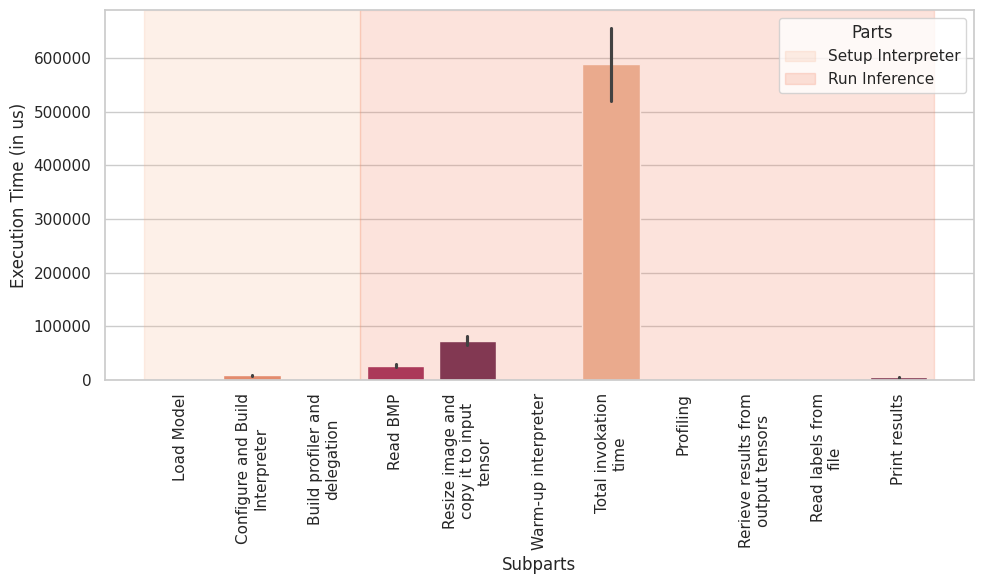

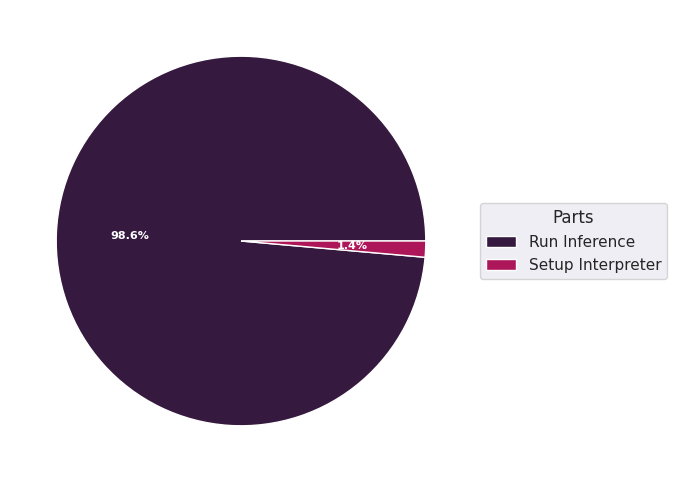

/tmp/ipykernel_300735/3586007223.py:30: UserWarning: 
The palette list has fewer values (6) than needed (12) and will cycle, which may produce an uninterpretable plot.
  sns.barplot(data=item, x='Subpart', y='Execution Time (in us)', order=subpart_order, palette=colors)


<Figure size 640x480 with 0 Axes>

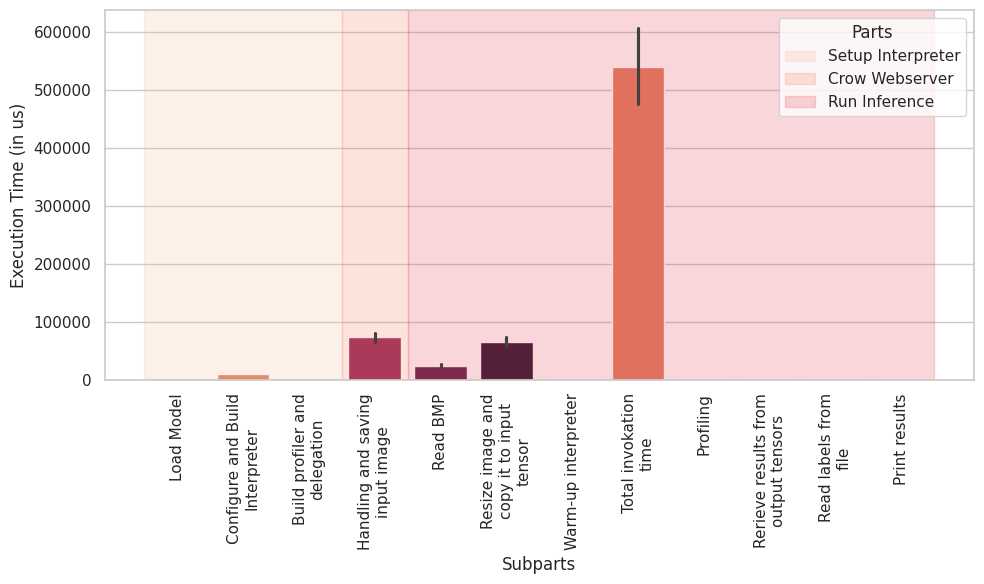

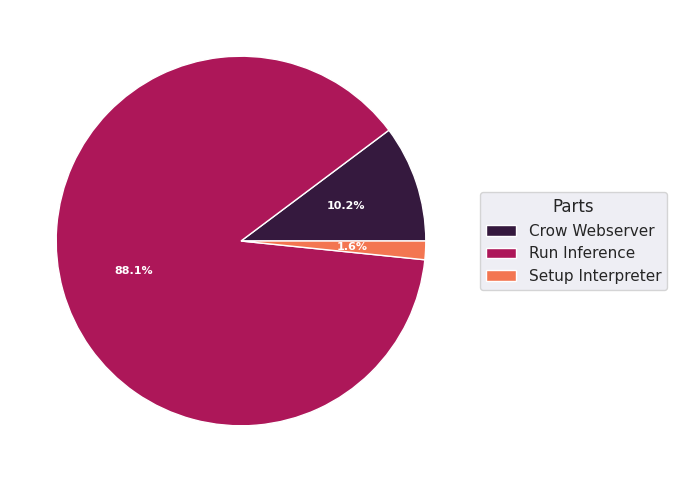

/tmp/ipykernel_300735/3586007223.py:30: UserWarning: 
The palette list has fewer values (3) than needed (12) and will cycle, which may produce an uninterpretable plot.
  sns.barplot(data=item, x='Subpart', y='Execution Time (in us)', order=subpart_order, palette=colors)


<Figure size 640x480 with 0 Axes>

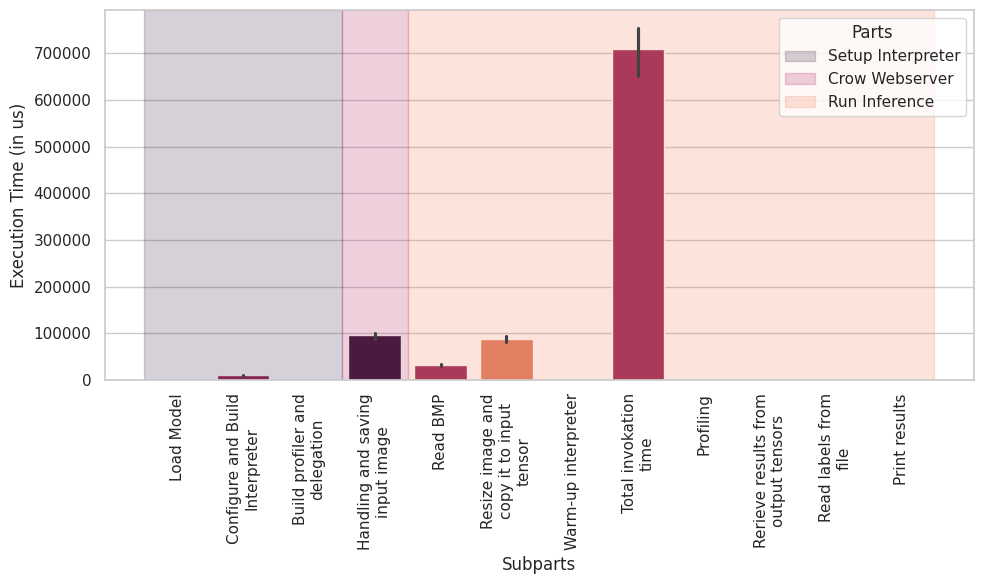

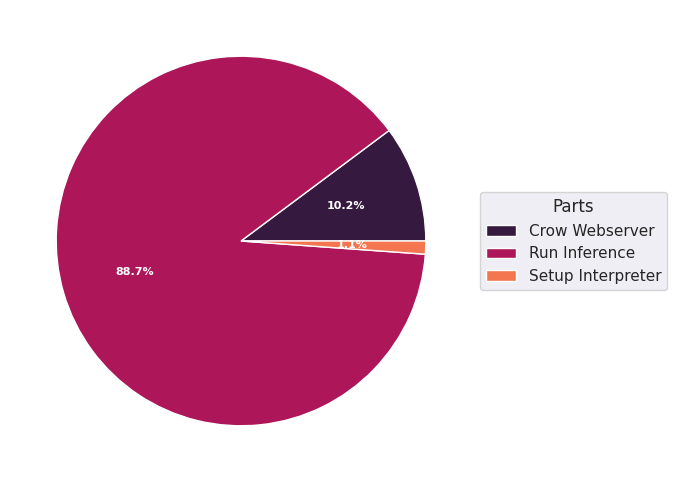

/tmp/ipykernel_300735/3586007223.py:30: UserWarning: 
The palette list has fewer values (3) than needed (12) and will cycle, which may produce an uninterpretable plot.
  sns.barplot(data=item, x='Subpart', y='Execution Time (in us)', order=subpart_order, palette=colors)


<Figure size 640x480 with 0 Axes>

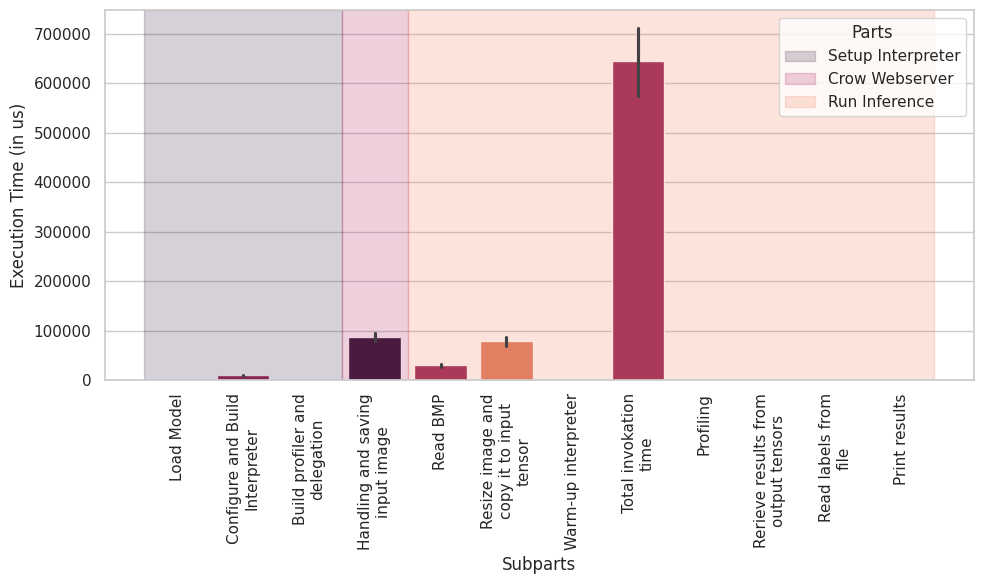

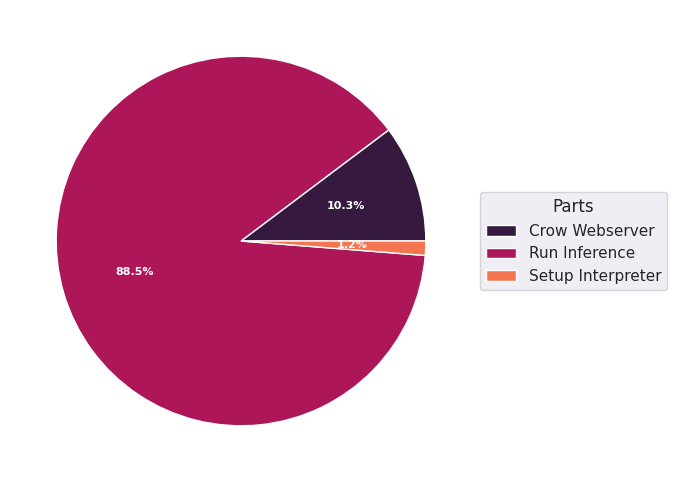

<Figure size 640x480 with 0 Axes>

In [153]:
df_exec_time = pd.read_csv(exp_dir + "/execution_time_by_parts.csv")
df_cpu_usage = pd.read_csv(exp_dir + "/cpu_usage.csv")
df_ram_usage = pd.read_csv(exp_dir + "/ram_usage.csv")

for imp in implementations:
    df_exec_time_imp = df_exec_time[df_exec_time["Implementation"] == imp]
    # mask = df_exec_time_imp[(df_exec_time_imp["Subpart"] != "Global time") & (df_exec_time_imp["Subpart"] != "Run inference") & (df_exec_time_imp["Subpart"] != "Average invokation time per loop")]
    df_exec_time_imp = df_exec_time_imp[(df_exec_time_imp["Subpart"] != "Global time") & (df_exec_time_imp["Subpart"] != "Run inference") & (df_exec_time_imp["Subpart"] != "Average invokation time per loop")]
    df_exec_time_imp['Subpart'] = df_exec_time_imp['Subpart'].apply(lambda x: textwrap.fill(x, width=20))
    df_cpu_usage_imp = df_cpu_usage[df_cpu_usage["Implementation"] == imp]
    df_ram_usage_imp = df_ram_usage[df_ram_usage["Implementation"] == imp]

    df_exec_time_imp_med = df_exec_time_imp.groupby(["Medium"])

    medium_group = df_exec_time_imp.groupby("Medium")

    colors = sns.color_palette('rocket')[::-1]

    part_subpart_order = df_exec_time_imp[["Part", "Subpart"]].drop_duplicates()
    part_order = part_subpart_order["Part"].unique()
    subpart_order = part_subpart_order["Subpart"].to_list()
    
    # Generate unique colors for each part
    # colors = plt.cm.viridis([i / float(len(part_order)) for i in range(len(part_order))])

    for med, item in medium_group:
        # Bar plot
        plt.figure(figsize=(10, 6))
        sns.set_style("whitegrid")
        sns.barplot(data=item, x='Subpart', y='Execution Time (in us)', order=subpart_order, palette=colors)

        # Add background colors
        start_idx = 0
        start_idx = 0
        for i, part in enumerate(part_order):
            part_count = len(part_subpart_order[part_subpart_order["Part"] == part])
            end_idx = start_idx + part_count
            plt.axvspan(start_idx - 0.5, end_idx - 0.5, color=colors[i], alpha=0.2, label=part)
            start_idx = end_idx
        
        plt.legend(title="Parts")
        plt.xlabel("Subparts")
        plt.xticks(rotation=90)
        plt.ylim(bottom=0)
        plt.tight_layout()
        plt.show
    
        plt.savefig(graphs_exec_time_dir + "/barplot_" + experiment_name.replace(' ', '_') + "_" + imp + "_" + med + ".pdf")

        # Pie plot
        fig, ax = plt.subplots(figsize=(10, 6), subplot_kw=dict(aspect="equal"))

        colors = sns.color_palette('rocket')[0::2] 
        sns.set_theme()

        data_by_part = item.groupby("Part").sum()
        data_by_part["Execution Time (in us)"] = data_by_part["Execution Time (in us)"] / data_by_part["Execution Time (in us)"].sum()

        wedges, texts, autotexts = ax.pie(data_by_part["Execution Time (in us)"], autopct='%1.1f%%', colors=colors, startangle=0)

        for text in plt.gca().texts:
            text.set_color('white')
            # text.set_fontsize(20)
        for autotext in autotexts:
            autotext.set_color('white')
            # autotext.set_fontsize(20)

        ax.legend(wedges, data_by_part.index.values,
                title="Parts",
                loc="center left",
                bbox_to_anchor=(1, 0, 0.5, 1))

        plt.setp(autotexts, size=8, weight="bold")

        plt.show()
        plt.savefig(graphs_exec_time_dir + "/pieplot_" + experiment_name.replace(' ', '_') + "_" + imp + "_" + med + ".pdf")

/tmp/ipykernel_300735/896414186.py:33: UserWarning: The palette list has more values (6) than needed (3), which may not be intended.
  sns.barplot(data=item_group, x='Execution Time (in us)', y='Part', orient="y", order=label_order, palette=colors)


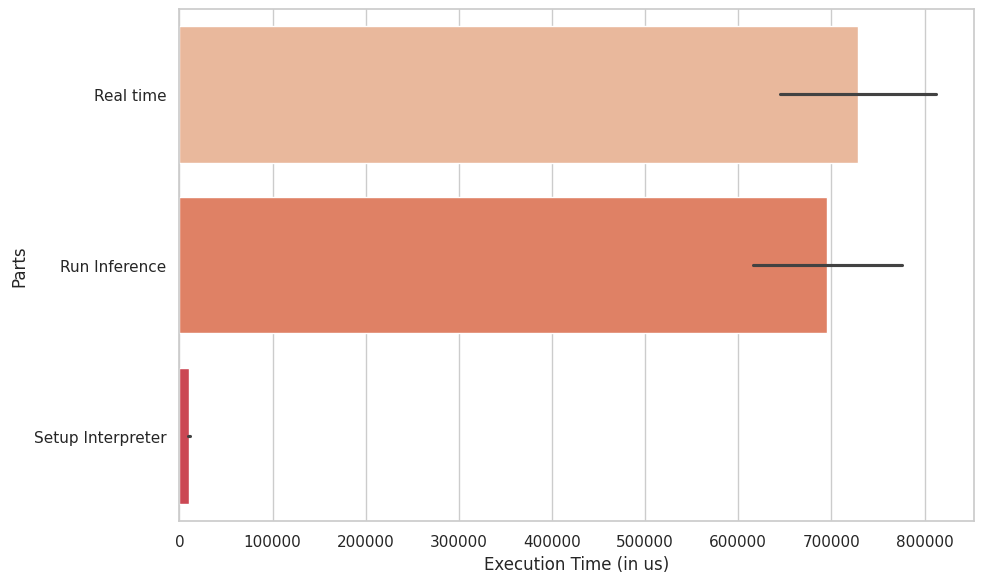

/tmp/ipykernel_300735/896414186.py:33: UserWarning: The palette list has more values (6) than needed (4), which may not be intended.
  sns.barplot(data=item_group, x='Execution Time (in us)', y='Part', orient="y", order=label_order, palette=colors)


<Figure size 640x480 with 0 Axes>

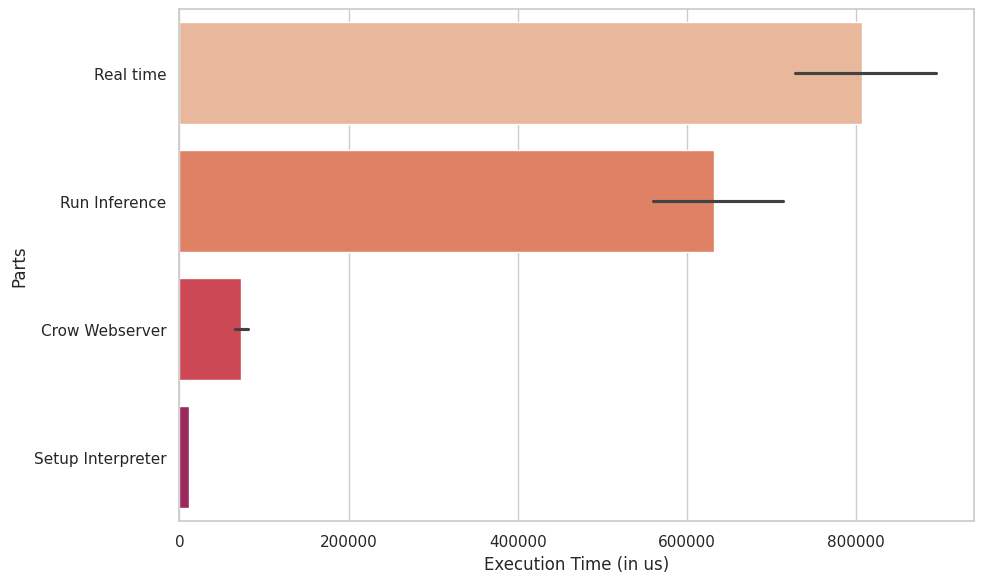

/tmp/ipykernel_300735/896414186.py:33: UserWarning: The palette list has more values (6) than needed (4), which may not be intended.
  sns.barplot(data=item_group, x='Execution Time (in us)', y='Part', orient="y", order=label_order, palette=colors)


<Figure size 640x480 with 0 Axes>

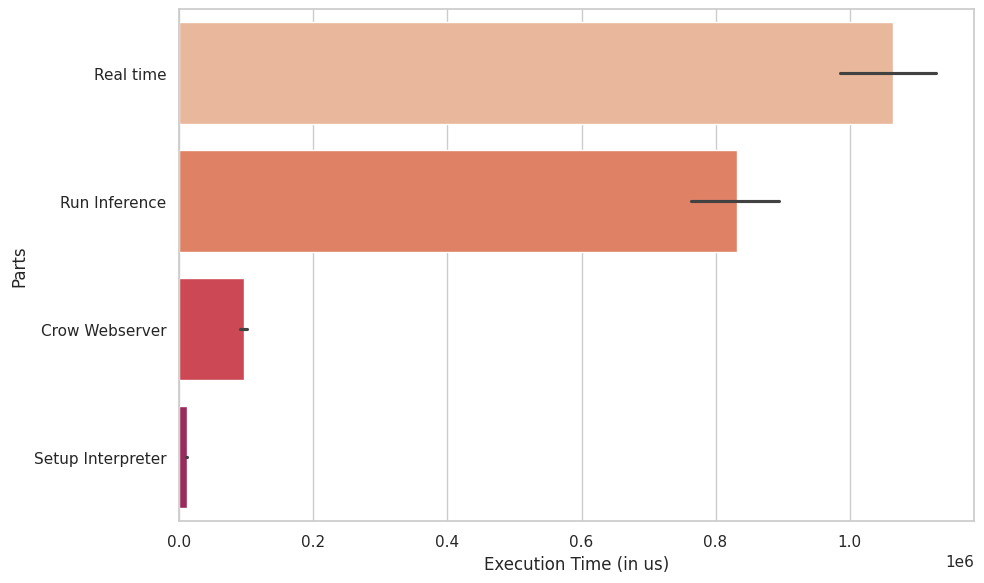

/tmp/ipykernel_300735/896414186.py:33: UserWarning: The palette list has more values (6) than needed (4), which may not be intended.
  sns.barplot(data=item_group, x='Execution Time (in us)', y='Part', orient="y", order=label_order, palette=colors)


<Figure size 640x480 with 0 Axes>

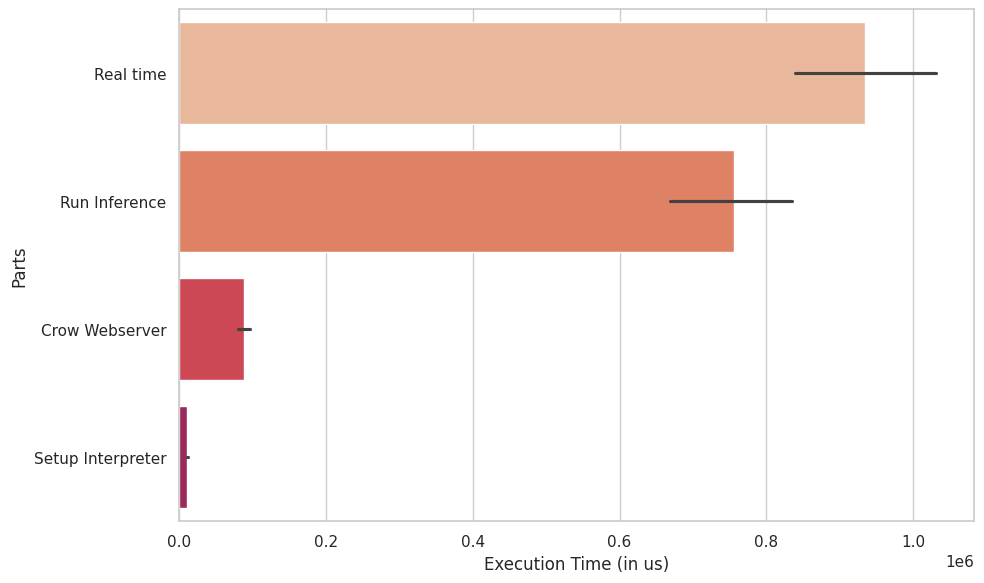

<Figure size 640x480 with 0 Axes>

In [154]:
df_exec_time = pd.read_csv(exp_dir + "/execution_time_by_parts.csv")
df_cpu_usage = pd.read_csv(exp_dir + "/cpu_usage.csv")
df_ram_usage = pd.read_csv(exp_dir + "/ram_usage.csv")

for imp in implementations:
    df_exec_time_imp = df_exec_time[df_exec_time["Implementation"] == imp]
    df_exec_time_imp = df_exec_time_imp[((df_exec_time_imp["Subpart"] != "Global time") | (df_exec_time_imp["Part"] == "Real time")) & (df_exec_time_imp["Subpart"] != "Run inference") & (df_exec_time_imp["Subpart"] != "Average invokation time per loop")]
    df_exec_time_imp['Subpart'] = df_exec_time_imp['Subpart'].apply(lambda x: textwrap.fill(x, width=20))
    df_cpu_usage_imp = df_cpu_usage[df_cpu_usage["Implementation"] == imp]
    df_ram_usage_imp = df_ram_usage[df_ram_usage["Implementation"] == imp]

    df_exec_time_imp_med = df_exec_time_imp.groupby(["Medium"])

    medium_group = df_exec_time_imp.groupby("Medium")

    colors = sns.color_palette('rocket')[::-1]
    # Generate unique colors for each part
    # colors = plt.cm.viridis([i / float(len(part_order)) for i in range(len(part_order))])

    for med, item in medium_group:
        # Process data
        item = item[["Iteration", "Part", "Execution Time (in us)"]]
        item_group = item.groupby(["Iteration", "Part"]).sum()

        # Get order
        label_order = item_group.groupby("Part").mean().sort_values(by=["Execution Time (in us)"], ascending=False)
        label_order.reset_index(inplace=True)
        label_order = label_order["Part"]

        # Bar plot
        plt.figure(figsize=(10, 6))
        sns.set_style("whitegrid")
        sns.barplot(data=item_group, x='Execution Time (in us)', y='Part', orient="y", order=label_order, palette=colors)
        
        # plt.xticks(rotation=90)
        plt.xlim(left=0)
        plt.ylabel("Parts")
        plt.tight_layout()
        plt.tight_layout()
        plt.show()
    
        plt.savefig(graphs_exec_time_dir + "/barplot_global_" + experiment_name.replace(' ', '_') + "_" + imp + "_" + med + ".pdf")


## Experiment 2: Analysis of the evolution of the execution time of each important part of the TensorFlow Lite application for classical setup with increasing number of inference threads

In [137]:
# Experiment setup
experiment_name = "Evolution of execution time with inference thread"
timestamp = timestamp=datetime.datetime.now() # Current timestamp

iteration = 20
ssh_info = "pptc@192.168.88.3"
ssh_ip = "192.168.88.3"
implementations = ["label_image", "label_image_with_crow"]
mediums = ["WiFi 2.4GHz 20-40MHz", "WiFi 5.0GHz 20-40-80MHz", "Ethernet"]
n_threads = [1, 2, 3, 4]
count_for_usage_script = 30 # correspond to the number of measure taken (1 per second)# Experiment setup

### Perform experiment

In [127]:
# Experiment path
exp_folder_name = experiment_name.replace(' ', '_') + "_" + timestamp.strftime("%Y%m%dT%H%M%S")
exp_folder_name = experiment_name.replace(' ', '_') + "_Final"
curr_exp_dir = global_res_dir + "/" + exp_folder_name

# Remote path
remote_exp_results_dir = "~/" + exp_folder_name + "/results"
remote_exp_cpu_usage_dir = remote_exp_results_dir + "/cpu_usage"
remote_exp_ram_usage_dir = remote_exp_results_dir + "/ram_usage"
remote_exp_scripts_dir = "~/" + exp_folder_name + "/scripts"

# Copy scripts on remote device
!{ssh_with_args} {ssh_info} "mkdir -p ~/{exp_folder_name}"
!{scp_with_args} -r scripts/ {ssh_info}:~/{exp_folder_name}

# Perform the experiment
for imp in implementations:
    imp_mediums = ["na"] if imp == "label_image" else mediums

    # Copy needed assets (executable and images)
    print(f"Copy assets for {imp} on remote device")
    !{scp_with_args} -r {assets_path}/{imp} {ssh_info}:~/{exp_folder_name}/{imp}

    for med in imp_mediums:
        # Validate config:
        print(f"Prepare next config:\n\tImplementation: {imp}\n\tMedium: {med}\n\t\n")
        time.sleep(2)
        v = input("Press ENTER to run the benchmark")
        print(f"Value : {v}")
        if v == "s": # stop
            break
        print("Run benchmark...")

        # Create remote workspace
        !{ssh_with_args} {ssh_info} "mkdir -p {remote_exp_cpu_usage_dir}; mkdir -p {remote_exp_ram_usage_dir}"

        # Implementation paths
        curr_exp_imp_dir = curr_exp_dir + "/" + imp.replace(' ', '_')
        curr_exp_imp_med_dir = curr_exp_imp_dir + ("/" + med.replace(' ', '_') if med != "na" else "")
        curr_exp_imp_raw_dir = curr_exp_imp_med_dir + "/raw_results"
        curr_exp_imp_res_dir = curr_exp_imp_med_dir + "/results"
        curr_exp_imp_raw_file = curr_exp_imp_raw_dir + "/execution_time_by_part.txt"

        # Create results dir
        path = Path(curr_exp_dir)
        path.mkdir(parents=True, exist_ok=True)
        path = Path(curr_exp_imp_dir)
        path.mkdir(parents=True, exist_ok=True)
        path = Path(curr_exp_imp_raw_dir)
        path.mkdir(parents=True, exist_ok=True)
        path = Path(curr_exp_imp_res_dir)
        path.mkdir(parents=True, exist_ok=True)

        # Print experiment setup in results file
        # Local for execution time
        with open(curr_exp_imp_raw_file, "w") as raw:
            raw.write(f"# SSH_INFO={ssh_info}\n")
            raw.write(f"# ITERATIONS={iteration}\n")
            raw.write(f"# IMPLEMENTATION={imp}\n")
            raw.write(f"# MEDIUM={med}\n")

        for t in n_threads:
            with open(curr_exp_imp_raw_file, "a") as raw:
                raw.write(f"\n# THREADS {t}\n")

            # Remote paths
            cpu_usage_remote_file = remote_exp_cpu_usage_dir + "/results_cpu_usage_" + imp + "_" + med.replace(' ', '_') + "_" + str(t) + ".txt"
            ram_usage_remote_file = remote_exp_ram_usage_dir + "/results_ram_usage_" + imp + "_" + med.replace(' ', '_') + "_" + str(t) + ".txt"

            # Remote for cpu and ram usage
            !{ssh_with_args} {ssh_info} "echo -e \"# SSH_INFO={ssh_info}\n# ITERATIONS={iteration}\n# IMPLEMENTATION={imp}\n# MEDIUM={med}\n# THREADS={t}\n# COUNT={count_for_usage_script}\n\" > {cpu_usage_remote_file}"
            !{ssh_with_args} {ssh_info} "echo -e \"# SSH_INFO={ssh_info}\n# ITERATIONS={iteration}\n# IMPLEMENTATION={imp}\n# MEDIUM={med}\n# THREADS={t}\n# COUNT={count_for_usage_script}\n\" > {ram_usage_remote_file}"

            # Perform test
            for i in range(iteration):
                # Print iteration
                print(f"Iteration {i}")
                with open(curr_exp_imp_raw_file, "a") as raw:
                    raw.write(f"\n# ITERATION {i}\n")
                !{ssh_with_args} {ssh_info} "echo -e \"\n# ITERATION {i}\n\" >> {cpu_usage_remote_file}"
                !{ssh_with_args} {ssh_info} "echo -e \"\n# ITERATION {i}\n\" >> {ram_usage_remote_file}"

                # Run cpu and ram usage script
                print("Start CPU and RAM usage scripts")
                
                cpu_usage_process = subprocess.Popen(f'{ssh_with_args} {ssh_info} "{remote_exp_scripts_dir}/cpu_usage_script.sh {count_for_usage_script} {cpu_usage_remote_file} 0"', shell=True)
                ram_usage_process = subprocess.Popen(f'{ssh_with_args} {ssh_info} "{remote_exp_scripts_dir}/ram_usage_script.sh {count_for_usage_script} {ram_usage_remote_file} 0"', shell=True)

                print("Sleep 3s")
                time.sleep(3) # To have more usage measures

                
                print("Perform measure")
                if imp == "label_image":
                    start_timestamp = int(datetime.datetime.now().timestamp()) # Timestamp at which the inference request started
                    !{ssh_with_args} {ssh_info} "cd ~/{exp_folder_name}/{imp}; (time ./{imp} -m mobilenet_v1_1.0_224.tflite -l labels.txt -i grace_hopper.bmp --num_threads {t} -d 1 -w 0)" &>> {curr_exp_imp_raw_file}

                    stop_timestamp = int(datetime.datetime.now().timestamp()) # Timestamp at which the inference request started
                else:
                    server_process = subprocess.Popen(f'{ssh_with_args} {ssh_info} "cd ~/{exp_folder_name}/{imp}; ./{imp} -c config.json -t {t}"', shell=True)
                    time.sleep(3)
                    
                    start_timestamp = int(datetime.datetime.now().timestamp()) # Timestamp at which the inference request started
                    !(time curl -X POST -F "image=@{assets_path}/label_image_with_crow/grace_hopper.bmp" http://{ssh_ip}:18080/label_image) &>> {curr_exp_imp_raw_file}

                    stop_timestamp = int(datetime.datetime.now().timestamp()) # Timestamp at which the inference request started
                    
                    # Kill server
                    print("Kill server")
                    server_process.kill()
                    !{ssh_with_args} {ssh_info} 'kill $(pidof {imp})'


                print("Sleep 3s")
                time.sleep(3)  # To have more usage measures

                print("Kill CPU and RAM usage scripts")
                cpu_usage_process.kill()
                ram_usage_process.kill()
                !{ssh_with_args} {ssh_info} 'kill $(pidof cpu_usage_script.sh)'
                !{ssh_with_args} {ssh_info} 'kill $(pidof ram_usage_script.sh)'

                !{ssh_with_args} {ssh_info} "echo \"# TIMESTAMP_START={start_timestamp}\" >> {cpu_usage_remote_file}; echo \"# TIMESTAMP_STOP={stop_timestamp}\" >> {cpu_usage_remote_file}"
                !{ssh_with_args} {ssh_info} "echo \"# TIMESTAMP_START={start_timestamp}\" >> {ram_usage_remote_file}; echo \"# TIMESTAMP_STOP={stop_timestamp}\" >> {ram_usage_remote_file}"

        print("Retrieve usage results and remove remote workspace")
        !{scp_with_args} -r {ssh_info}:{remote_exp_cpu_usage_dir} {curr_exp_imp_raw_dir}
        !{scp_with_args} -r {ssh_info}:{remote_exp_ram_usage_dir} {curr_exp_imp_raw_dir}

        !{ssh_with_args} {ssh_info} "rm -rf {remote_exp_cpu_usage_dir}; rm -rf {remote_exp_ram_usage_dir}"

# Remove remote workspace
!{ssh_with_args} {ssh_info} "rm -rf ~/{exp_folder_name}"

cpu_usage_script.sh                           100% 1189   724.0KB/s   00:00    
ram_usage_script.sh                           100% 1253   860.1KB/s   00:00    
Copy assets for label_image_with_crow on remote device
label_image_with_crow                         100% 5425KB  11.1MB/s   00:00    
mobilenet_v1_1.0_224.tflite                   100%   16MB   3.3MB/s   00:04    
grace_hopper.bmp                              100%  919KB  10.7MB/s   00:00    
labels.txt                                    100%   10KB   3.0MB/s   00:00    
config.json                                   100%  530   334.8KB/s   00:00    
Prepare next config:
	Implementation: label_image_with_crow
	Medium: Ethernet
	

Value : 
Run benchmark...
Iteration 0
Start CPU and RAM usage scripts
Sleep 3s


Perform measure


INFO: Loaded model ./mobilenet_v1_1.0_224.tflite
INFO: resolved reporter
(2024-08-11 21:54:20) [INFO    ] Crow/master server is running at http://0.0.0.0:18080 using 4 threads
(2024-08-11 21:54:20) [INFO    ] Call `app.loglevel(crow::LogLevel::Warning)` to hide Info level logs.
(2024-08-11 21:54:23) [INFO    ] Request: 192.168.88.200:38454 0xb5d4b200 HTTP/1.1 POST /label_image


Kill server


(2024-08-11 21:54:24) [INFO    ] Response: 0xb5d4b200 /label_image 200 0


Sleep 3s


(2024-08-11 21:54:25) [INFO    ] Closing IO service 0xb580b6f0
(2024-08-11 21:54:25) [INFO    ] Closing IO service 0xb580b6f4
(2024-08-11 21:54:25) [INFO    ] Closing IO service 0xb580b6f8
(2024-08-11 21:54:25) [INFO    ] Closing main IO service (0xb5d394dc)
(2024-08-11 21:54:25) [INFO    ] Exiting.


Kill CPU and RAM usage scripts
Iteration 1
Start CPU and RAM usage scripts
Sleep 3s


Perform measure


INFO: Loaded model ./mobilenet_v1_1.0_224.tflite
INFO: resolved reporter
(2024-08-11 21:54:34) [INFO    ] Crow/master server is running at http://0.0.0.0:18080 using 4 threads
(2024-08-11 21:54:34) [INFO    ] Call `app.loglevel(crow::LogLevel::Warning)` to hide Info level logs.
(2024-08-11 21:54:37) [INFO    ] Request: 192.168.88.200:53652 0xb5ce8200 HTTP/1.1 POST /label_image


Kill server


(2024-08-11 21:54:37) [INFO    ] Response: 0xb5ce8200 /label_image 200 0


Sleep 3s


(2024-08-11 21:54:38) [INFO    ] Closing IO service 0xb57a86f0
(2024-08-11 21:54:38) [INFO    ] Closing IO service 0xb57a86f4
(2024-08-11 21:54:38) [INFO    ] Closing IO service 0xb57a86f8
(2024-08-11 21:54:38) [INFO    ] Closing main IO service (0xb5cd64dc)
(2024-08-11 21:54:38) [INFO    ] Exiting.


Kill CPU and RAM usage scripts
Iteration 2
Start CPU and RAM usage scripts
Sleep 3s


Perform measure


INFO: Loaded model ./mobilenet_v1_1.0_224.tflite
INFO: resolved reporter
(2024-08-11 21:54:47) [INFO    ] Crow/master server is running at http://0.0.0.0:18080 using 4 threads
(2024-08-11 21:54:47) [INFO    ] Call `app.loglevel(crow::LogLevel::Warning)` to hide Info level logs.
(2024-08-11 21:54:50) [INFO    ] Request: 192.168.88.200:51876 0xb5c88200 HTTP/1.1 POST /label_image


Kill server


(2024-08-11 21:54:51) [INFO    ] Response: 0xb5c88200 /label_image 200 0


Sleep 3s


(2024-08-11 21:54:51) [INFO    ] Closing IO service 0xb57486f0
(2024-08-11 21:54:51) [INFO    ] Closing IO service 0xb57486f4
(2024-08-11 21:54:51) [INFO    ] Closing IO service 0xb57486f8
(2024-08-11 21:54:51) [INFO    ] Closing main IO service (0xb5c764dc)
(2024-08-11 21:54:51) [INFO    ] Exiting.


Kill CPU and RAM usage scripts
Iteration 3
Start CPU and RAM usage scripts
Sleep 3s


Perform measure


INFO: Loaded model ./mobilenet_v1_1.0_224.tflite
INFO: resolved reporter
(2024-08-11 21:55:01) [INFO    ] Crow/master server is running at http://0.0.0.0:18080 using 4 threads
(2024-08-11 21:55:01) [INFO    ] Call `app.loglevel(crow::LogLevel::Warning)` to hide Info level logs.
(2024-08-11 21:55:03) [INFO    ] Request: 192.168.88.200:53266 0xb5cd0200 HTTP/1.1 POST /label_image


Kill server


(2024-08-11 21:55:04) [INFO    ] Response: 0xb5cd0200 /label_image 200 0


Sleep 3s


(2024-08-11 21:55:05) [INFO    ] Closing IO service 0xb57906f0
(2024-08-11 21:55:05) [INFO    ] Closing IO service 0xb57906f4
(2024-08-11 21:55:05) [INFO    ] Closing IO service 0xb57906f8
(2024-08-11 21:55:05) [INFO    ] Closing main IO service (0xb5cbe4dc)
(2024-08-11 21:55:05) [INFO    ] Exiting.


Kill CPU and RAM usage scripts
Iteration 4
Start CPU and RAM usage scripts
Sleep 3s


Perform measure


INFO: Loaded model ./mobilenet_v1_1.0_224.tflite
INFO: resolved reporter
(2024-08-11 21:55:14) [INFO    ] Crow/master server is running at http://0.0.0.0:18080 using 4 threads
(2024-08-11 21:55:14) [INFO    ] Call `app.loglevel(crow::LogLevel::Warning)` to hide Info level logs.
(2024-08-11 21:55:17) [INFO    ] Request: 192.168.88.200:57994 0xb5d14200 HTTP/1.1 POST /label_image


Kill server


(2024-08-11 21:55:18) [INFO    ] Response: 0xb5d14200 /label_image 200 0


Sleep 3s


(2024-08-11 21:55:18) [INFO    ] Closing IO service 0xb57d46f0
(2024-08-11 21:55:18) [INFO    ] Closing IO service 0xb57d46f4
(2024-08-11 21:55:18) [INFO    ] Closing IO service 0xb57d46f8
(2024-08-11 21:55:18) [INFO    ] Closing main IO service (0xb5d024dc)
(2024-08-11 21:55:18) [INFO    ] Exiting.


Kill CPU and RAM usage scripts
Iteration 5
Start CPU and RAM usage scripts
Sleep 3s


Perform measure


INFO: Loaded model ./mobilenet_v1_1.0_224.tflite
INFO: resolved reporter
(2024-08-11 21:55:28) [INFO    ] Crow/master server is running at http://0.0.0.0:18080 using 4 threads
(2024-08-11 21:55:28) [INFO    ] Call `app.loglevel(crow::LogLevel::Warning)` to hide Info level logs.
(2024-08-11 21:55:31) [INFO    ] Request: 192.168.88.200:51632 0xb5cef200 HTTP/1.1 POST /label_image


Kill server


(2024-08-11 21:55:31) [INFO    ] Response: 0xb5cef200 /label_image 200 0


Sleep 3s


(2024-08-11 21:55:32) [INFO    ] Closing IO service 0xb57af6f0
(2024-08-11 21:55:32) [INFO    ] Closing IO service 0xb57af6f4
(2024-08-11 21:55:32) [INFO    ] Closing IO service 0xb57af6f8
(2024-08-11 21:55:32) [INFO    ] Closing main IO service (0xb5cdd4dc)
(2024-08-11 21:55:32) [INFO    ] Exiting.


Kill CPU and RAM usage scripts
Iteration 6
Start CPU and RAM usage scripts
Sleep 3s


Perform measure


INFO: Loaded model ./mobilenet_v1_1.0_224.tflite
INFO: resolved reporter
(2024-08-11 21:55:41) [INFO    ] Crow/master server is running at http://0.0.0.0:18080 using 4 threads
(2024-08-11 21:55:41) [INFO    ] Call `app.loglevel(crow::LogLevel::Warning)` to hide Info level logs.
(2024-08-11 21:55:44) [INFO    ] Request: 192.168.88.200:37142 0xb5cd8200 HTTP/1.1 POST /label_image


Kill server


(2024-08-11 21:55:45) [INFO    ] Response: 0xb5cd8200 /label_image 200 0


Sleep 3s


(2024-08-11 21:55:45) [INFO    ] Closing IO service 0xb57986f0
(2024-08-11 21:55:45) [INFO    ] Closing IO service 0xb57986f4
(2024-08-11 21:55:45) [INFO    ] Closing IO service 0xb57986f8
(2024-08-11 21:55:45) [INFO    ] Closing main IO service (0xb5cc64dc)
(2024-08-11 21:55:45) [INFO    ] Exiting.


Kill CPU and RAM usage scripts
Iteration 7
Start CPU and RAM usage scripts
Sleep 3s


Perform measure


INFO: Loaded model ./mobilenet_v1_1.0_224.tflite
INFO: resolved reporter
(2024-08-11 21:55:55) [INFO    ] Crow/master server is running at http://0.0.0.0:18080 using 4 threads
(2024-08-11 21:55:55) [INFO    ] Call `app.loglevel(crow::LogLevel::Warning)` to hide Info level logs.
(2024-08-11 21:55:57) [INFO    ] Request: 192.168.88.200:37360 0xb5c73200 HTTP/1.1 POST /label_image


Kill server


(2024-08-11 21:55:58) [INFO    ] Response: 0xb5c73200 /label_image 200 0


Sleep 3s


(2024-08-11 21:55:59) [INFO    ] Closing IO service 0xb57336f0
(2024-08-11 21:55:59) [INFO    ] Closing IO service 0xb57336f4
(2024-08-11 21:55:59) [INFO    ] Closing IO service 0xb57336f8
(2024-08-11 21:55:59) [INFO    ] Closing main IO service (0xb5c614dc)
(2024-08-11 21:55:59) [INFO    ] Exiting.


Kill CPU and RAM usage scripts
Iteration 8
Start CPU and RAM usage scripts
Sleep 3s


Perform measure


INFO: Loaded model ./mobilenet_v1_1.0_224.tflite
INFO: resolved reporter
(2024-08-11 21:56:08) [INFO    ] Crow/master server is running at http://0.0.0.0:18080 using 4 threads
(2024-08-11 21:56:08) [INFO    ] Call `app.loglevel(crow::LogLevel::Warning)` to hide Info level logs.
(2024-08-11 21:56:11) [INFO    ] Request: 192.168.88.200:58136 0xb5c75200 HTTP/1.1 POST /label_image


Kill server


(2024-08-11 21:56:12) [INFO    ] Response: 0xb5c75200 /label_image 200 0


Sleep 3s


(2024-08-11 21:56:13) [INFO    ] Closing IO service 0xb57356f0
(2024-08-11 21:56:13) [INFO    ] Closing IO service 0xb57356f4
(2024-08-11 21:56:13) [INFO    ] Closing IO service 0xb57356f8
(2024-08-11 21:56:13) [INFO    ] Closing main IO service (0xb5c634dc)
(2024-08-11 21:56:13) [INFO    ] Exiting.


Kill CPU and RAM usage scripts
Iteration 9
Start CPU and RAM usage scripts
Sleep 3s


Perform measure


INFO: Loaded model ./mobilenet_v1_1.0_224.tflite
INFO: resolved reporter
(2024-08-11 21:56:22) [INFO    ] Crow/master server is running at http://0.0.0.0:18080 using 4 threads
(2024-08-11 21:56:22) [INFO    ] Call `app.loglevel(crow::LogLevel::Warning)` to hide Info level logs.
(2024-08-11 21:56:25) [INFO    ] Request: 192.168.88.200:44382 0xb5c95200 HTTP/1.1 POST /label_image


Kill server


(2024-08-11 21:56:26) [INFO    ] Response: 0xb5c95200 /label_image 200 0


Sleep 3s


(2024-08-11 21:56:26) [INFO    ] Closing IO service 0xb57556f0
(2024-08-11 21:56:26) [INFO    ] Closing IO service 0xb57556f4
(2024-08-11 21:56:26) [INFO    ] Closing IO service 0xb57556f8
(2024-08-11 21:56:26) [INFO    ] Closing main IO service (0xb5c834dc)
(2024-08-11 21:56:26) [INFO    ] Exiting.


Kill CPU and RAM usage scripts
Iteration 10
Start CPU and RAM usage scripts
Sleep 3s


Perform measure


INFO: Loaded model ./mobilenet_v1_1.0_224.tflite
INFO: resolved reporter
(2024-08-11 21:56:36) [INFO    ] Crow/master server is running at http://0.0.0.0:18080 using 4 threads
(2024-08-11 21:56:36) [INFO    ] Call `app.loglevel(crow::LogLevel::Warning)` to hide Info level logs.
(2024-08-11 21:56:38) [INFO    ] Request: 192.168.88.200:42512 0xb5d19200 HTTP/1.1 POST /label_image


Kill server


(2024-08-11 21:56:39) [INFO    ] Response: 0xb5d19200 /label_image 200 0


Sleep 3s


(2024-08-11 21:56:39) [INFO    ] Closing IO service 0xb57d96f0
(2024-08-11 21:56:39) [INFO    ] Closing IO service 0xb57d96f4
(2024-08-11 21:56:39) [INFO    ] Closing IO service 0xb57d96f8
(2024-08-11 21:56:39) [INFO    ] Closing main IO service (0xb5d074dc)
(2024-08-11 21:56:39) [INFO    ] Exiting.


Kill CPU and RAM usage scripts
Iteration 11
Start CPU and RAM usage scripts
Sleep 3s


Perform measure


INFO: Loaded model ./mobilenet_v1_1.0_224.tflite
INFO: resolved reporter
(2024-08-11 21:56:49) [INFO    ] Crow/master server is running at http://0.0.0.0:18080 using 4 threads
(2024-08-11 21:56:49) [INFO    ] Call `app.loglevel(crow::LogLevel::Warning)` to hide Info level logs.
(2024-08-11 21:56:52) [INFO    ] Request: 192.168.88.200:49324 0xb5d4c200 HTTP/1.1 POST /label_image


Kill server


(2024-08-11 21:56:52) [INFO    ] Response: 0xb5d4c200 /label_image 200 0


Sleep 3s


(2024-08-11 21:56:53) [INFO    ] Closing IO service 0xb580c6f0
(2024-08-11 21:56:53) [INFO    ] Closing IO service 0xb580c6f4
(2024-08-11 21:56:53) [INFO    ] Closing IO service 0xb580c6f8
(2024-08-11 21:56:53) [INFO    ] Closing main IO service (0xb5d3a4dc)
(2024-08-11 21:56:53) [INFO    ] Exiting.


Kill CPU and RAM usage scripts
Iteration 12
Start CPU and RAM usage scripts
Sleep 3s


Perform measure


INFO: Loaded model ./mobilenet_v1_1.0_224.tflite
INFO: resolved reporter
(2024-08-11 21:57:02) [INFO    ] Crow/master server is running at http://0.0.0.0:18080 using 4 threads
(2024-08-11 21:57:02) [INFO    ] Call `app.loglevel(crow::LogLevel::Warning)` to hide Info level logs.
(2024-08-11 21:57:05) [INFO    ] Request: 192.168.88.200:55800 0xb5c8f200 HTTP/1.1 POST /label_image


Kill server


(2024-08-11 21:57:05) [INFO    ] Response: 0xb5c8f200 /label_image 200 0


Sleep 3s


(2024-08-11 21:57:06) [INFO    ] Closing IO service 0xb574f6f0
(2024-08-11 21:57:06) [INFO    ] Closing IO service 0xb574f6f4
(2024-08-11 21:57:06) [INFO    ] Closing IO service 0xb574f6f8
(2024-08-11 21:57:06) [INFO    ] Closing main IO service (0xb5c7d4dc)
(2024-08-11 21:57:06) [INFO    ] Exiting.


Kill CPU and RAM usage scripts
Iteration 13
Start CPU and RAM usage scripts
Sleep 3s


Perform measure


INFO: Loaded model ./mobilenet_v1_1.0_224.tflite
INFO: resolved reporter
(2024-08-11 21:57:15) [INFO    ] Crow/master server is running at http://0.0.0.0:18080 using 4 threads
(2024-08-11 21:57:15) [INFO    ] Call `app.loglevel(crow::LogLevel::Warning)` to hide Info level logs.
(2024-08-11 21:57:18) [INFO    ] Request: 192.168.88.200:57938 0xb5c65200 HTTP/1.1 POST /label_image


Kill server


(2024-08-11 21:57:19) [INFO    ] Response: 0xb5c65200 /label_image 200 0


Sleep 3s


(2024-08-11 21:57:19) [INFO    ] Closing IO service 0xb57256f0
(2024-08-11 21:57:19) [INFO    ] Closing IO service 0xb57256f4
(2024-08-11 21:57:19) [INFO    ] Closing IO service 0xb57256f8
(2024-08-11 21:57:19) [INFO    ] Closing main IO service (0xb5c534dc)
(2024-08-11 21:57:19) [INFO    ] Exiting.


Kill CPU and RAM usage scripts
Iteration 14
Start CPU and RAM usage scripts
Sleep 3s


Perform measure


INFO: Loaded model ./mobilenet_v1_1.0_224.tflite
INFO: resolved reporter
(2024-08-11 21:57:29) [INFO    ] Crow/master server is running at http://0.0.0.0:18080 using 4 threads
(2024-08-11 21:57:29) [INFO    ] Call `app.loglevel(crow::LogLevel::Warning)` to hide Info level logs.
(2024-08-11 21:57:31) [INFO    ] Request: 192.168.88.200:57336 0xb5ca4200 HTTP/1.1 POST /label_image


Kill server


(2024-08-11 21:57:32) [INFO    ] Response: 0xb5ca4200 /label_image 200 0


Sleep 3s


(2024-08-11 21:57:32) [INFO    ] Closing IO service 0xb57646f0
(2024-08-11 21:57:32) [INFO    ] Closing IO service 0xb57646f4
(2024-08-11 21:57:32) [INFO    ] Closing IO service 0xb57646f8
(2024-08-11 21:57:32) [INFO    ] Closing main IO service (0xb5c924dc)
(2024-08-11 21:57:32) [INFO    ] Exiting.


Kill CPU and RAM usage scripts
Iteration 15
Start CPU and RAM usage scripts
Sleep 3s


Perform measure


INFO: Loaded model ./mobilenet_v1_1.0_224.tflite
INFO: resolved reporter
(2024-08-11 21:57:42) [INFO    ] Crow/master server is running at http://0.0.0.0:18080 using 4 threads
(2024-08-11 21:57:42) [INFO    ] Call `app.loglevel(crow::LogLevel::Warning)` to hide Info level logs.
(2024-08-11 21:57:45) [INFO    ] Request: 192.168.88.200:34904 0xb5c6f200 HTTP/1.1 POST /label_image


Kill server


(2024-08-11 21:57:45) [INFO    ] Response: 0xb5c6f200 /label_image 200 0


Sleep 3s


(2024-08-11 21:57:46) [INFO    ] Closing IO service 0xb572f6f0
(2024-08-11 21:57:46) [INFO    ] Closing IO service 0xb572f6f4
(2024-08-11 21:57:46) [INFO    ] Closing IO service 0xb572f6f8
(2024-08-11 21:57:46) [INFO    ] Closing main IO service (0xb5c5d4dc)
(2024-08-11 21:57:46) [INFO    ] Exiting.


Kill CPU and RAM usage scripts
Iteration 16
Start CPU and RAM usage scripts
Sleep 3s


Perform measure


INFO: Loaded model ./mobilenet_v1_1.0_224.tflite
INFO: resolved reporter
(2024-08-11 21:57:55) [INFO    ] Crow/master server is running at http://0.0.0.0:18080 using 4 threads
(2024-08-11 21:57:55) [INFO    ] Call `app.loglevel(crow::LogLevel::Warning)` to hide Info level logs.
(2024-08-11 21:57:58) [INFO    ] Request: 192.168.88.200:56752 0xb5c69200 HTTP/1.1 POST /label_image


Kill server


(2024-08-11 21:57:58) [INFO    ] Response: 0xb5c69200 /label_image 200 0


Sleep 3s


(2024-08-11 21:57:59) [INFO    ] Closing IO service 0xb57296f0
(2024-08-11 21:57:59) [INFO    ] Closing IO service 0xb57296f4
(2024-08-11 21:57:59) [INFO    ] Closing IO service 0xb57296f8
(2024-08-11 21:57:59) [INFO    ] Closing main IO service (0xb5c574dc)
(2024-08-11 21:57:59) [INFO    ] Exiting.


Kill CPU and RAM usage scripts
Iteration 17
Start CPU and RAM usage scripts
Sleep 3s


Perform measure


INFO: Loaded model ./mobilenet_v1_1.0_224.tflite
INFO: resolved reporter
(2024-08-11 21:58:08) [INFO    ] Crow/master server is running at http://0.0.0.0:18080 using 4 threads
(2024-08-11 21:58:08) [INFO    ] Call `app.loglevel(crow::LogLevel::Warning)` to hide Info level logs.
(2024-08-11 21:58:11) [INFO    ] Request: 192.168.88.200:48006 0xb5d24200 HTTP/1.1 POST /label_image


Kill server


(2024-08-11 21:58:12) [INFO    ] Response: 0xb5d24200 /label_image 200 0


Sleep 3s


(2024-08-11 21:58:12) [INFO    ] Closing IO service 0xb57e46f0
(2024-08-11 21:58:12) [INFO    ] Closing IO service 0xb57e46f4
(2024-08-11 21:58:12) [INFO    ] Closing IO service 0xb57e46f8
(2024-08-11 21:58:12) [INFO    ] Closing main IO service (0xb5d124dc)
(2024-08-11 21:58:12) [INFO    ] Exiting.


Kill CPU and RAM usage scripts
Iteration 18
Start CPU and RAM usage scripts
Sleep 3s


Perform measure


INFO: Loaded model ./mobilenet_v1_1.0_224.tflite
INFO: resolved reporter
(2024-08-11 21:58:21) [INFO    ] Crow/master server is running at http://0.0.0.0:18080 using 4 threads
(2024-08-11 21:58:21) [INFO    ] Call `app.loglevel(crow::LogLevel::Warning)` to hide Info level logs.
(2024-08-11 21:58:24) [INFO    ] Request: 192.168.88.200:42388 0xb5d19200 HTTP/1.1 POST /label_image


Kill server


(2024-08-11 21:58:25) [INFO    ] Response: 0xb5d19200 /label_image 200 0


Sleep 3s


(2024-08-11 21:58:25) [INFO    ] Closing IO service 0xb57d96f0
(2024-08-11 21:58:25) [INFO    ] Closing IO service 0xb57d96f4
(2024-08-11 21:58:25) [INFO    ] Closing IO service 0xb57d96f8
(2024-08-11 21:58:25) [INFO    ] Closing main IO service (0xb5d074dc)
(2024-08-11 21:58:25) [INFO    ] Exiting.


Kill CPU and RAM usage scripts
Iteration 19
Start CPU and RAM usage scripts
Sleep 3s


Perform measure


INFO: Loaded model ./mobilenet_v1_1.0_224.tflite
INFO: resolved reporter
(2024-08-11 21:58:35) [INFO    ] Crow/master server is running at http://0.0.0.0:18080 using 4 threads
(2024-08-11 21:58:35) [INFO    ] Call `app.loglevel(crow::LogLevel::Warning)` to hide Info level logs.
(2024-08-11 21:58:37) [INFO    ] Request: 192.168.88.200:54422 0xb5cd3200 HTTP/1.1 POST /label_image


Kill server


(2024-08-11 21:58:38) [INFO    ] Response: 0xb5cd3200 /label_image 200 0


Sleep 3s


(2024-08-11 21:58:38) [INFO    ] Closing IO service 0xb57936f0
(2024-08-11 21:58:38) [INFO    ] Closing IO service 0xb57936f4
(2024-08-11 21:58:38) [INFO    ] Closing IO service 0xb57936f8
(2024-08-11 21:58:38) [INFO    ] Closing main IO service (0xb5cc14dc)
(2024-08-11 21:58:38) [INFO    ] Exiting.


Kill CPU and RAM usage scripts
Iteration 0
Start CPU and RAM usage scripts
Sleep 3s


Perform measure


INFO: Loaded model ./mobilenet_v1_1.0_224.tflite
INFO: resolved reporter
(2024-08-11 21:58:49) [INFO    ] Crow/master server is running at http://0.0.0.0:18080 using 4 threads
(2024-08-11 21:58:49) [INFO    ] Call `app.loglevel(crow::LogLevel::Warning)` to hide Info level logs.
(2024-08-11 21:58:52) [INFO    ] Request: 192.168.88.200:54690 0xb5c8e210 HTTP/1.1 POST /label_image


Kill server


(2024-08-11 21:58:53) [INFO    ] Response: 0xb5c8e210 /label_image 200 0


Sleep 3s


(2024-08-11 21:58:53) [INFO    ] Closing IO service 0xb476a6d0
(2024-08-11 21:58:53) [INFO    ] Closing IO service 0xb476a6d4
(2024-08-11 21:58:53) [INFO    ] Closing IO service 0xb476a6d8
(2024-08-11 21:58:53) [INFO    ] Closing main IO service (0xb5c7b34c)
(2024-08-11 21:58:53) [INFO    ] Exiting.


Kill CPU and RAM usage scripts
Iteration 1
Start CPU and RAM usage scripts
Sleep 3s


Perform measure


INFO: Loaded model ./mobilenet_v1_1.0_224.tflite
INFO: resolved reporter
(2024-08-11 21:59:03) [INFO    ] Crow/master server is running at http://0.0.0.0:18080 using 4 threads
(2024-08-11 21:59:03) [INFO    ] Call `app.loglevel(crow::LogLevel::Warning)` to hide Info level logs.
(2024-08-11 21:59:05) [INFO    ] Request: 192.168.88.200:52912 0xb5c57210 HTTP/1.1 POST /label_image


Kill server


(2024-08-11 21:59:07) [INFO    ] Response: 0xb5c57210 /label_image 200 0


Sleep 3s


(2024-08-11 21:59:07) [INFO    ] Closing IO service 0xb47336d0
(2024-08-11 21:59:07) [INFO    ] Closing IO service 0xb47336d4
(2024-08-11 21:59:07) [INFO    ] Closing IO service 0xb47336d8
(2024-08-11 21:59:07) [INFO    ] Closing main IO service (0xb5c4434c)
(2024-08-11 21:59:07) [INFO    ] Exiting.


Kill CPU and RAM usage scripts
Iteration 2
Start CPU and RAM usage scripts
Sleep 3s


Perform measure


INFO: Loaded model ./mobilenet_v1_1.0_224.tflite
INFO: resolved reporter
(2024-08-11 21:59:17) [INFO    ] Crow/master server is running at http://0.0.0.0:18080 using 4 threads
(2024-08-11 21:59:17) [INFO    ] Call `app.loglevel(crow::LogLevel::Warning)` to hide Info level logs.
(2024-08-11 21:59:19) [INFO    ] Request: 192.168.88.200:57398 0xb5ce6210 HTTP/1.1 POST /label_image


Kill server


(2024-08-11 21:59:21) [INFO    ] Response: 0xb5ce6210 /label_image 200 0


Sleep 3s


(2024-08-11 21:59:21) [INFO    ] Closing IO service 0xb47c26d0
(2024-08-11 21:59:21) [INFO    ] Closing IO service 0xb47c26d4
(2024-08-11 21:59:21) [INFO    ] Closing IO service 0xb47c26d8
(2024-08-11 21:59:21) [INFO    ] Closing main IO service (0xb5cd334c)
(2024-08-11 21:59:21) [INFO    ] Exiting.


Kill CPU and RAM usage scripts
Iteration 3
Start CPU and RAM usage scripts
Sleep 3s


Perform measure


INFO: Loaded model ./mobilenet_v1_1.0_224.tflite
INFO: resolved reporter
(2024-08-11 21:59:31) [INFO    ] Crow/master server is running at http://0.0.0.0:18080 using 4 threads
(2024-08-11 21:59:31) [INFO    ] Call `app.loglevel(crow::LogLevel::Warning)` to hide Info level logs.
(2024-08-11 21:59:33) [INFO    ] Request: 192.168.88.200:45404 0xb5c93210 HTTP/1.1 POST /label_image


Kill server


(2024-08-11 21:59:35) [INFO    ] Response: 0xb5c93210 /label_image 200 0


Sleep 3s


(2024-08-11 21:59:35) [INFO    ] Closing IO service 0xb476f6d0
(2024-08-11 21:59:35) [INFO    ] Closing IO service 0xb476f6d4
(2024-08-11 21:59:35) [INFO    ] Closing IO service 0xb476f6d8
(2024-08-11 21:59:35) [INFO    ] Closing main IO service (0xb5c8034c)
(2024-08-11 21:59:35) [INFO    ] Exiting.


Kill CPU and RAM usage scripts
Iteration 4
Start CPU and RAM usage scripts
Sleep 3s


Perform measure


INFO: Loaded model ./mobilenet_v1_1.0_224.tflite
INFO: resolved reporter
(2024-08-11 21:59:44) [INFO    ] Crow/master server is running at http://0.0.0.0:18080 using 4 threads
(2024-08-11 21:59:44) [INFO    ] Call `app.loglevel(crow::LogLevel::Warning)` to hide Info level logs.
(2024-08-11 21:59:47) [INFO    ] Request: 192.168.88.200:46620 0xb5d55210 HTTP/1.1 POST /label_image


Kill server


(2024-08-11 21:59:48) [INFO    ] Response: 0xb5d55210 /label_image 200 0


Sleep 3s


(2024-08-11 21:59:49) [INFO    ] Closing IO service 0xb48316d0
(2024-08-11 21:59:49) [INFO    ] Closing IO service 0xb48316d4
(2024-08-11 21:59:49) [INFO    ] Closing IO service 0xb48316d8
(2024-08-11 21:59:49) [INFO    ] Closing main IO service (0xb5d4234c)
(2024-08-11 21:59:49) [INFO    ] Exiting.


Kill CPU and RAM usage scripts
Iteration 5
Start CPU and RAM usage scripts
Sleep 3s


Perform measure


INFO: Loaded model ./mobilenet_v1_1.0_224.tflite
INFO: resolved reporter
(2024-08-11 21:59:58) [INFO    ] Crow/master server is running at http://0.0.0.0:18080 using 4 threads
(2024-08-11 21:59:58) [INFO    ] Call `app.loglevel(crow::LogLevel::Warning)` to hide Info level logs.
(2024-08-11 22:00:01) [INFO    ] Request: 192.168.88.200:44800 0xb5cc4210 HTTP/1.1 POST /label_image


Kill server


(2024-08-11 22:00:02) [INFO    ] Response: 0xb5cc4210 /label_image 200 0


Sleep 3s


(2024-08-11 22:00:03) [INFO    ] Closing IO service 0xb47a06d0
(2024-08-11 22:00:03) [INFO    ] Closing IO service 0xb47a06d4
(2024-08-11 22:00:03) [INFO    ] Closing IO service 0xb47a06d8
(2024-08-11 22:00:03) [INFO    ] Closing main IO service (0xb5cb134c)
(2024-08-11 22:00:03) [INFO    ] Exiting.


Kill CPU and RAM usage scripts
Iteration 6
Start CPU and RAM usage scripts
Sleep 3s


Perform measure


INFO: Loaded model ./mobilenet_v1_1.0_224.tflite
INFO: resolved reporter
(2024-08-11 22:00:12) [INFO    ] Crow/master server is running at http://0.0.0.0:18080 using 4 threads
(2024-08-11 22:00:12) [INFO    ] Call `app.loglevel(crow::LogLevel::Warning)` to hide Info level logs.
(2024-08-11 22:00:15) [INFO    ] Request: 192.168.88.200:53060 0xb5d0a210 HTTP/1.1 POST /label_image


Kill server


(2024-08-11 22:00:16) [INFO    ] Response: 0xb5d0a210 /label_image 200 0


Sleep 3s


(2024-08-11 22:00:17) [INFO    ] Closing IO service 0xb47e66d0
(2024-08-11 22:00:17) [INFO    ] Closing IO service 0xb47e66d4
(2024-08-11 22:00:17) [INFO    ] Closing IO service 0xb47e66d8
(2024-08-11 22:00:17) [INFO    ] Closing main IO service (0xb5cf734c)
(2024-08-11 22:00:17) [INFO    ] Exiting.


Kill CPU and RAM usage scripts
Iteration 7
Start CPU and RAM usage scripts
Sleep 3s


Perform measure


INFO: Loaded model ./mobilenet_v1_1.0_224.tflite
INFO: resolved reporter
(2024-08-11 22:00:26) [INFO    ] Crow/master server is running at http://0.0.0.0:18080 using 4 threads
(2024-08-11 22:00:26) [INFO    ] Call `app.loglevel(crow::LogLevel::Warning)` to hide Info level logs.
(2024-08-11 22:00:29) [INFO    ] Request: 192.168.88.200:36660 0xb5d38210 HTTP/1.1 POST /label_image


Kill server


(2024-08-11 22:00:30) [INFO    ] Response: 0xb5d38210 /label_image 200 0


Sleep 3s


(2024-08-11 22:00:30) [INFO    ] Closing IO service 0xb48146d0
(2024-08-11 22:00:30) [INFO    ] Closing IO service 0xb48146d4
(2024-08-11 22:00:30) [INFO    ] Closing IO service 0xb48146d8
(2024-08-11 22:00:30) [INFO    ] Closing main IO service (0xb5d2534c)
(2024-08-11 22:00:30) [INFO    ] Exiting.


Kill CPU and RAM usage scripts
Iteration 8
Start CPU and RAM usage scripts
Sleep 3s


Perform measure


INFO: Loaded model ./mobilenet_v1_1.0_224.tflite
INFO: resolved reporter
(2024-08-11 22:00:40) [INFO    ] Crow/master server is running at http://0.0.0.0:18080 using 4 threads
(2024-08-11 22:00:40) [INFO    ] Call `app.loglevel(crow::LogLevel::Warning)` to hide Info level logs.
(2024-08-11 22:00:43) [INFO    ] Request: 192.168.88.200:47842 0xb5ce6210 HTTP/1.1 POST /label_image


Kill server


(2024-08-11 22:00:44) [INFO    ] Response: 0xb5ce6210 /label_image 200 0


Sleep 3s


(2024-08-11 22:00:44) [INFO    ] Closing IO service 0xb47c26d0
(2024-08-11 22:00:44) [INFO    ] Closing IO service 0xb47c26d4
(2024-08-11 22:00:44) [INFO    ] Closing IO service 0xb47c26d8
(2024-08-11 22:00:44) [INFO    ] Closing main IO service (0xb5cd334c)
(2024-08-11 22:00:44) [INFO    ] Exiting.


Kill CPU and RAM usage scripts
Iteration 9
Start CPU and RAM usage scripts
Sleep 3s


Perform measure


INFO: Loaded model ./mobilenet_v1_1.0_224.tflite
INFO: resolved reporter
(2024-08-11 22:00:54) [INFO    ] Crow/master server is running at http://0.0.0.0:18080 using 4 threads
(2024-08-11 22:00:54) [INFO    ] Call `app.loglevel(crow::LogLevel::Warning)` to hide Info level logs.
(2024-08-11 22:00:56) [INFO    ] Request: 192.168.88.200:57896 0xb5d50210 HTTP/1.1 POST /label_image


Kill server


(2024-08-11 22:00:58) [INFO    ] Response: 0xb5d50210 /label_image 200 0


Sleep 3s


(2024-08-11 22:00:58) [INFO    ] Closing IO service 0xb482c6d0
(2024-08-11 22:00:58) [INFO    ] Closing IO service 0xb482c6d4
(2024-08-11 22:00:58) [INFO    ] Closing IO service 0xb482c6d8
(2024-08-11 22:00:58) [INFO    ] Closing main IO service (0xb5d3d34c)
(2024-08-11 22:00:58) [INFO    ] Exiting.


Kill CPU and RAM usage scripts
Iteration 10
Start CPU and RAM usage scripts
Sleep 3s


Perform measure


INFO: Loaded model ./mobilenet_v1_1.0_224.tflite
INFO: resolved reporter
(2024-08-11 22:01:07) [INFO    ] Crow/master server is running at http://0.0.0.0:18080 using 4 threads
(2024-08-11 22:01:07) [INFO    ] Call `app.loglevel(crow::LogLevel::Warning)` to hide Info level logs.
(2024-08-11 22:01:10) [INFO    ] Request: 192.168.88.200:41814 0xb5c57210 HTTP/1.1 POST /label_image


Kill server


(2024-08-11 22:01:12) [INFO    ] Response: 0xb5c57210 /label_image 200 0


Sleep 3s


(2024-08-11 22:01:12) [INFO    ] Closing IO service 0xb47336d0
(2024-08-11 22:01:12) [INFO    ] Closing IO service 0xb47336d4
(2024-08-11 22:01:12) [INFO    ] Closing IO service 0xb47336d8
(2024-08-11 22:01:12) [INFO    ] Closing main IO service (0xb5c4434c)
(2024-08-11 22:01:12) [INFO    ] Exiting.


Kill CPU and RAM usage scripts
Iteration 11
Start CPU and RAM usage scripts
Sleep 3s


Perform measure


INFO: Loaded model ./mobilenet_v1_1.0_224.tflite
INFO: resolved reporter
(2024-08-11 22:01:21) [INFO    ] Crow/master server is running at http://0.0.0.0:18080 using 4 threads
(2024-08-11 22:01:21) [INFO    ] Call `app.loglevel(crow::LogLevel::Warning)` to hide Info level logs.
(2024-08-11 22:01:24) [INFO    ] Request: 192.168.88.200:38866 0xb5cc8210 HTTP/1.1 POST /label_image


Kill server


(2024-08-11 22:01:25) [INFO    ] Response: 0xb5cc8210 /label_image 200 0


Sleep 3s


(2024-08-11 22:01:26) [INFO    ] Closing IO service 0xb47a46d0
(2024-08-11 22:01:26) [INFO    ] Closing IO service 0xb47a46d4
(2024-08-11 22:01:26) [INFO    ] Closing IO service 0xb47a46d8
(2024-08-11 22:01:26) [INFO    ] Closing main IO service (0xb5cb534c)
(2024-08-11 22:01:26) [INFO    ] Exiting.


Kill CPU and RAM usage scripts
Iteration 12
Start CPU and RAM usage scripts
Sleep 3s


Perform measure


INFO: Loaded model ./mobilenet_v1_1.0_224.tflite
INFO: resolved reporter
(2024-08-11 22:01:35) [INFO    ] Crow/master server is running at http://0.0.0.0:18080 using 4 threads
(2024-08-11 22:01:35) [INFO    ] Call `app.loglevel(crow::LogLevel::Warning)` to hide Info level logs.
(2024-08-11 22:01:38) [INFO    ] Request: 192.168.88.200:42238 0xb5c8c210 HTTP/1.1 POST /label_image


Kill server


(2024-08-11 22:01:39) [INFO    ] Response: 0xb5c8c210 /label_image 200 0


Sleep 3s


(2024-08-11 22:01:40) [INFO    ] Closing IO service 0xb47686d0
(2024-08-11 22:01:40) [INFO    ] Closing IO service 0xb47686d4
(2024-08-11 22:01:40) [INFO    ] Closing IO service 0xb47686d8
(2024-08-11 22:01:40) [INFO    ] Closing main IO service (0xb5c7934c)
(2024-08-11 22:01:40) [INFO    ] Exiting.


Kill CPU and RAM usage scripts
Iteration 13
Start CPU and RAM usage scripts
Sleep 3s


Perform measure


INFO: Loaded model ./mobilenet_v1_1.0_224.tflite
INFO: resolved reporter
(2024-08-11 22:01:49) [INFO    ] Crow/master server is running at http://0.0.0.0:18080 using 4 threads
(2024-08-11 22:01:49) [INFO    ] Call `app.loglevel(crow::LogLevel::Warning)` to hide Info level logs.
(2024-08-11 22:01:52) [INFO    ] Request: 192.168.88.200:53230 0xb5cb3210 HTTP/1.1 POST /label_image


Kill server


(2024-08-11 22:01:53) [INFO    ] Response: 0xb5cb3210 /label_image 200 0


Sleep 3s


(2024-08-11 22:01:54) [INFO    ] Closing IO service 0xb478f6d0
(2024-08-11 22:01:54) [INFO    ] Closing IO service 0xb478f6d4
(2024-08-11 22:01:54) [INFO    ] Closing IO service 0xb478f6d8
(2024-08-11 22:01:54) [INFO    ] Closing main IO service (0xb5ca034c)
(2024-08-11 22:01:54) [INFO    ] Exiting.


Kill CPU and RAM usage scripts
Iteration 14
Start CPU and RAM usage scripts
Sleep 3s


Perform measure


INFO: Loaded model ./mobilenet_v1_1.0_224.tflite
INFO: resolved reporter
(2024-08-11 22:02:03) [INFO    ] Crow/master server is running at http://0.0.0.0:18080 using 4 threads
(2024-08-11 22:02:03) [INFO    ] Call `app.loglevel(crow::LogLevel::Warning)` to hide Info level logs.
(2024-08-11 22:02:06) [INFO    ] Request: 192.168.88.200:48488 0xb5cab210 HTTP/1.1 POST /label_image


Kill server


(2024-08-11 22:02:07) [INFO    ] Response: 0xb5cab210 /label_image 200 0


Sleep 3s


(2024-08-11 22:02:08) [INFO    ] Closing IO service 0xb47876d0
(2024-08-11 22:02:08) [INFO    ] Closing IO service 0xb47876d4
(2024-08-11 22:02:08) [INFO    ] Closing IO service 0xb47876d8
(2024-08-11 22:02:08) [INFO    ] Closing main IO service (0xb5c9834c)
(2024-08-11 22:02:08) [INFO    ] Exiting.


Kill CPU and RAM usage scripts
Iteration 15
Start CPU and RAM usage scripts
Sleep 3s


Perform measure


INFO: Loaded model ./mobilenet_v1_1.0_224.tflite
INFO: resolved reporter
(2024-08-11 22:02:17) [INFO    ] Crow/master server is running at http://0.0.0.0:18080 using 4 threads
(2024-08-11 22:02:17) [INFO    ] Call `app.loglevel(crow::LogLevel::Warning)` to hide Info level logs.
(2024-08-11 22:02:20) [INFO    ] Request: 192.168.88.200:37626 0xb5c65210 HTTP/1.1 POST /label_image


Kill server


(2024-08-11 22:02:21) [INFO    ] Response: 0xb5c65210 /label_image 200 0


Sleep 3s


(2024-08-11 22:02:22) [INFO    ] Closing IO service 0xb47416d0
(2024-08-11 22:02:22) [INFO    ] Closing IO service 0xb47416d4
(2024-08-11 22:02:22) [INFO    ] Closing IO service 0xb47416d8
(2024-08-11 22:02:22) [INFO    ] Closing main IO service (0xb5c5234c)
(2024-08-11 22:02:22) [INFO    ] Exiting.


Kill CPU and RAM usage scripts
Iteration 16
Start CPU and RAM usage scripts
Sleep 3s


Perform measure


INFO: Loaded model ./mobilenet_v1_1.0_224.tflite
INFO: resolved reporter
(2024-08-11 22:02:31) [INFO    ] Crow/master server is running at http://0.0.0.0:18080 using 4 threads
(2024-08-11 22:02:31) [INFO    ] Call `app.loglevel(crow::LogLevel::Warning)` to hide Info level logs.
(2024-08-11 22:02:34) [INFO    ] Request: 192.168.88.200:50162 0xb5c8d210 HTTP/1.1 POST /label_image


Kill server


(2024-08-11 22:02:35) [INFO    ] Response: 0xb5c8d210 /label_image 200 0


Sleep 3s


(2024-08-11 22:02:36) [INFO    ] Closing IO service 0xb47696d0
(2024-08-11 22:02:36) [INFO    ] Closing IO service 0xb47696d4
(2024-08-11 22:02:36) [INFO    ] Closing IO service 0xb47696d8
(2024-08-11 22:02:36) [INFO    ] Closing main IO service (0xb5c7a34c)
(2024-08-11 22:02:36) [INFO    ] Exiting.


Kill CPU and RAM usage scripts
Iteration 17
Start CPU and RAM usage scripts
Sleep 3s


Perform measure


INFO: Loaded model ./mobilenet_v1_1.0_224.tflite
INFO: resolved reporter
(2024-08-11 22:02:45) [INFO    ] Crow/master server is running at http://0.0.0.0:18080 using 4 threads
(2024-08-11 22:02:45) [INFO    ] Call `app.loglevel(crow::LogLevel::Warning)` to hide Info level logs.
(2024-08-11 22:02:48) [INFO    ] Request: 192.168.88.200:42834 0xb5cf7210 HTTP/1.1 POST /label_image


Kill server


(2024-08-11 22:02:49) [INFO    ] Response: 0xb5cf7210 /label_image 200 0


Sleep 3s


(2024-08-11 22:02:50) [INFO    ] Closing IO service 0xb47d36d0
(2024-08-11 22:02:50) [INFO    ] Closing IO service 0xb47d36d4
(2024-08-11 22:02:50) [INFO    ] Closing IO service 0xb47d36d8
(2024-08-11 22:02:50) [INFO    ] Closing main IO service (0xb5ce434c)
(2024-08-11 22:02:50) [INFO    ] Exiting.


Kill CPU and RAM usage scripts
Iteration 18
Start CPU and RAM usage scripts
Sleep 3s


Perform measure


INFO: Loaded model ./mobilenet_v1_1.0_224.tflite
INFO: resolved reporter
(2024-08-11 22:02:59) [INFO    ] Crow/master server is running at http://0.0.0.0:18080 using 4 threads
(2024-08-11 22:02:59) [INFO    ] Call `app.loglevel(crow::LogLevel::Warning)` to hide Info level logs.
(2024-08-11 22:03:02) [INFO    ] Request: 192.168.88.200:48314 0xb5c79210 HTTP/1.1 POST /label_image


Kill server


(2024-08-11 22:03:03) [INFO    ] Response: 0xb5c79210 /label_image 200 0


Sleep 3s


(2024-08-11 22:03:04) [INFO    ] Closing IO service 0xb47556d0
(2024-08-11 22:03:04) [INFO    ] Closing IO service 0xb47556d4
(2024-08-11 22:03:04) [INFO    ] Closing IO service 0xb47556d8
(2024-08-11 22:03:04) [INFO    ] Closing main IO service (0xb5c6634c)
(2024-08-11 22:03:04) [INFO    ] Exiting.


Kill CPU and RAM usage scripts
Iteration 19
Start CPU and RAM usage scripts
Sleep 3s


Perform measure


INFO: Loaded model ./mobilenet_v1_1.0_224.tflite
INFO: resolved reporter
(2024-08-11 22:03:13) [INFO    ] Crow/master server is running at http://0.0.0.0:18080 using 4 threads
(2024-08-11 22:03:13) [INFO    ] Call `app.loglevel(crow::LogLevel::Warning)` to hide Info level logs.
(2024-08-11 22:03:16) [INFO    ] Request: 192.168.88.200:40190 0xb5c88210 HTTP/1.1 POST /label_image


Kill server


(2024-08-11 22:03:17) [INFO    ] Response: 0xb5c88210 /label_image 200 0


Sleep 3s


(2024-08-11 22:03:18) [INFO    ] Closing IO service 0xb47646d0
(2024-08-11 22:03:18) [INFO    ] Closing IO service 0xb47646d4
(2024-08-11 22:03:18) [INFO    ] Closing IO service 0xb47646d8
(2024-08-11 22:03:18) [INFO    ] Closing main IO service (0xb5c7534c)
(2024-08-11 22:03:18) [INFO    ] Exiting.


Kill CPU and RAM usage scripts
Iteration 0
Start CPU and RAM usage scripts
Sleep 3s


Perform measure


INFO: Loaded model ./mobilenet_v1_1.0_224.tflite
INFO: resolved reporter
(2024-08-11 22:03:28) [INFO    ] Crow/master server is running at http://0.0.0.0:18080 using 4 threads
(2024-08-11 22:03:28) [INFO    ] Call `app.loglevel(crow::LogLevel::Warning)` to hide Info level logs.
(2024-08-11 22:03:31) [INFO    ] Request: 192.168.88.200:44130 0xb5ca6210 HTTP/1.1 POST /label_image


Kill server


(2024-08-11 22:03:32) [INFO    ] Response: 0xb5ca6210 /label_image 200 0


Sleep 3s


(2024-08-11 22:03:33) [INFO    ] Closing IO service 0xb47826d0
(2024-08-11 22:03:33) [INFO    ] Closing IO service 0xb47826d4
(2024-08-11 22:03:33) [INFO    ] Closing IO service 0xb47826d8
(2024-08-11 22:03:33) [INFO    ] Closing main IO service (0xb5c9334c)
(2024-08-11 22:03:33) [INFO    ] Exiting.


Kill CPU and RAM usage scripts
Iteration 1
Start CPU and RAM usage scripts
Sleep 3s


Perform measure


INFO: Loaded model ./mobilenet_v1_1.0_224.tflite
INFO: resolved reporter
(2024-08-11 22:03:42) [INFO    ] Crow/master server is running at http://0.0.0.0:18080 using 4 threads
(2024-08-11 22:03:42) [INFO    ] Call `app.loglevel(crow::LogLevel::Warning)` to hide Info level logs.
(2024-08-11 22:03:45) [INFO    ] Request: 192.168.88.200:60112 0xb5d38210 HTTP/1.1 POST /label_image


Kill server


(2024-08-11 22:03:46) [INFO    ] Response: 0xb5d38210 /label_image 200 0


Sleep 3s


(2024-08-11 22:03:46) [INFO    ] Closing IO service 0xb48146d0
(2024-08-11 22:03:46) [INFO    ] Closing IO service 0xb48146d4
(2024-08-11 22:03:46) [INFO    ] Closing IO service 0xb48146d8
(2024-08-11 22:03:46) [INFO    ] Closing main IO service (0xb5d2534c)
(2024-08-11 22:03:46) [INFO    ] Exiting.


Kill CPU and RAM usage scripts
Iteration 2
Start CPU and RAM usage scripts
Sleep 3s


Perform measure


INFO: Loaded model ./mobilenet_v1_1.0_224.tflite
INFO: resolved reporter
(2024-08-11 22:03:56) [INFO    ] Crow/master server is running at http://0.0.0.0:18080 using 4 threads
(2024-08-11 22:03:56) [INFO    ] Call `app.loglevel(crow::LogLevel::Warning)` to hide Info level logs.
(2024-08-11 22:03:59) [INFO    ] Request: 192.168.88.200:35264 0xb5c67210 HTTP/1.1 POST /label_image


Kill server


(2024-08-11 22:04:00) [INFO    ] Response: 0xb5c67210 /label_image 200 0


Sleep 3s


(2024-08-11 22:04:00) [INFO    ] Closing IO service 0xb47436d0
(2024-08-11 22:04:00) [INFO    ] Closing IO service 0xb47436d4
(2024-08-11 22:04:00) [INFO    ] Closing IO service 0xb47436d8
(2024-08-11 22:04:00) [INFO    ] Closing main IO service (0xb5c5434c)
(2024-08-11 22:04:00) [INFO    ] Exiting.


Kill CPU and RAM usage scripts
Iteration 3
Start CPU and RAM usage scripts
Sleep 3s


Perform measure


INFO: Loaded model ./mobilenet_v1_1.0_224.tflite
INFO: resolved reporter
(2024-08-11 22:04:10) [INFO    ] Crow/master server is running at http://0.0.0.0:18080 using 4 threads
(2024-08-11 22:04:10) [INFO    ] Call `app.loglevel(crow::LogLevel::Warning)` to hide Info level logs.
(2024-08-11 22:04:12) [INFO    ] Request: 192.168.88.200:56092 0xb5c6b210 HTTP/1.1 POST /label_image


Kill server


(2024-08-11 22:04:13) [INFO    ] Response: 0xb5c6b210 /label_image 200 0


Sleep 3s


(2024-08-11 22:04:14) [INFO    ] Closing IO service 0xb47476d0
(2024-08-11 22:04:14) [INFO    ] Closing IO service 0xb47476d4
(2024-08-11 22:04:14) [INFO    ] Closing IO service 0xb47476d8
(2024-08-11 22:04:14) [INFO    ] Closing main IO service (0xb5c5834c)
(2024-08-11 22:04:14) [INFO    ] Exiting.


Kill CPU and RAM usage scripts
Iteration 4
Start CPU and RAM usage scripts
Sleep 3s


Perform measure


INFO: Loaded model ./mobilenet_v1_1.0_224.tflite
INFO: resolved reporter
(2024-08-11 22:04:23) [INFO    ] Crow/master server is running at http://0.0.0.0:18080 using 4 threads
(2024-08-11 22:04:23) [INFO    ] Call `app.loglevel(crow::LogLevel::Warning)` to hide Info level logs.
(2024-08-11 22:04:26) [INFO    ] Request: 192.168.88.200:36458 0xb5c76210 HTTP/1.1 POST /label_image


Kill server


(2024-08-11 22:04:27) [INFO    ] Response: 0xb5c76210 /label_image 200 0


Sleep 3s


(2024-08-11 22:04:28) [INFO    ] Closing IO service 0xb47526d0
(2024-08-11 22:04:28) [INFO    ] Closing IO service 0xb47526d4
(2024-08-11 22:04:28) [INFO    ] Closing IO service 0xb47526d8
(2024-08-11 22:04:28) [INFO    ] Closing main IO service (0xb5c6334c)
(2024-08-11 22:04:28) [INFO    ] Exiting.


Kill CPU and RAM usage scripts
Iteration 5
Start CPU and RAM usage scripts
Sleep 3s


Perform measure


INFO: Loaded model ./mobilenet_v1_1.0_224.tflite
INFO: resolved reporter
(2024-08-11 22:04:37) [INFO    ] Crow/master server is running at http://0.0.0.0:18080 using 4 threads
(2024-08-11 22:04:37) [INFO    ] Call `app.loglevel(crow::LogLevel::Warning)` to hide Info level logs.
(2024-08-11 22:04:40) [INFO    ] Request: 192.168.88.200:36974 0xb5d4d210 HTTP/1.1 POST /label_image


Kill server


(2024-08-11 22:04:41) [INFO    ] Response: 0xb5d4d210 /label_image 200 0


Sleep 3s


(2024-08-11 22:04:42) [INFO    ] Closing IO service 0xb48296d0
(2024-08-11 22:04:42) [INFO    ] Closing IO service 0xb48296d4
(2024-08-11 22:04:42) [INFO    ] Closing IO service 0xb48296d8
(2024-08-11 22:04:42) [INFO    ] Closing main IO service (0xb5d3a34c)
(2024-08-11 22:04:42) [INFO    ] Exiting.


Kill CPU and RAM usage scripts
Iteration 6
Start CPU and RAM usage scripts
Sleep 3s


Perform measure


INFO: Loaded model ./mobilenet_v1_1.0_224.tflite
INFO: resolved reporter
(2024-08-11 22:04:51) [INFO    ] Crow/master server is running at http://0.0.0.0:18080 using 4 threads
(2024-08-11 22:04:51) [INFO    ] Call `app.loglevel(crow::LogLevel::Warning)` to hide Info level logs.
(2024-08-11 22:04:54) [INFO    ] Request: 192.168.88.200:46366 0xb5d39210 HTTP/1.1 POST /label_image


Kill server


(2024-08-11 22:04:55) [INFO    ] Response: 0xb5d39210 /label_image 200 0


Sleep 3s


(2024-08-11 22:04:56) [INFO    ] Closing IO service 0xb48156d0
(2024-08-11 22:04:56) [INFO    ] Closing IO service 0xb48156d4
(2024-08-11 22:04:56) [INFO    ] Closing IO service 0xb48156d8
(2024-08-11 22:04:56) [INFO    ] Closing main IO service (0xb5d2634c)
(2024-08-11 22:04:56) [INFO    ] Exiting.


Kill CPU and RAM usage scripts
Iteration 7
Start CPU and RAM usage scripts
Sleep 3s


Perform measure


INFO: Loaded model ./mobilenet_v1_1.0_224.tflite
INFO: resolved reporter
(2024-08-11 22:05:05) [INFO    ] Crow/master server is running at http://0.0.0.0:18080 using 4 threads
(2024-08-11 22:05:05) [INFO    ] Call `app.loglevel(crow::LogLevel::Warning)` to hide Info level logs.
(2024-08-11 22:05:08) [INFO    ] Request: 192.168.88.200:55482 0xb5cd0210 HTTP/1.1 POST /label_image


Kill server


(2024-08-11 22:05:09) [INFO    ] Response: 0xb5cd0210 /label_image 200 0


Sleep 3s


(2024-08-11 22:05:10) [INFO    ] Closing IO service 0xb47ac6d0
(2024-08-11 22:05:10) [INFO    ] Closing IO service 0xb47ac6d4
(2024-08-11 22:05:10) [INFO    ] Closing IO service 0xb47ac6d8
(2024-08-11 22:05:10) [INFO    ] Closing main IO service (0xb5cbd34c)
(2024-08-11 22:05:10) [INFO    ] Exiting.


Kill CPU and RAM usage scripts
Iteration 8
Start CPU and RAM usage scripts
Sleep 3s


Perform measure


INFO: Loaded model ./mobilenet_v1_1.0_224.tflite
INFO: resolved reporter
(2024-08-11 22:05:19) [INFO    ] Crow/master server is running at http://0.0.0.0:18080 using 4 threads
(2024-08-11 22:05:19) [INFO    ] Call `app.loglevel(crow::LogLevel::Warning)` to hide Info level logs.
(2024-08-11 22:05:22) [INFO    ] Request: 192.168.88.200:56630 0xb5c86210 HTTP/1.1 POST /label_image


Kill server


(2024-08-11 22:05:23) [INFO    ] Response: 0xb5c86210 /label_image 200 0


Sleep 3s


(2024-08-11 22:05:23) [INFO    ] Closing IO service 0xb47626d0
(2024-08-11 22:05:23) [INFO    ] Closing IO service 0xb47626d4
(2024-08-11 22:05:23) [INFO    ] Closing IO service 0xb47626d8
(2024-08-11 22:05:23) [INFO    ] Closing main IO service (0xb5c7334c)
(2024-08-11 22:05:23) [INFO    ] Exiting.


Kill CPU and RAM usage scripts
Iteration 9
Start CPU and RAM usage scripts
Sleep 3s


Perform measure


INFO: Loaded model ./mobilenet_v1_1.0_224.tflite
INFO: resolved reporter
(2024-08-11 22:05:33) [INFO    ] Crow/master server is running at http://0.0.0.0:18080 using 4 threads
(2024-08-11 22:05:33) [INFO    ] Call `app.loglevel(crow::LogLevel::Warning)` to hide Info level logs.
(2024-08-11 22:05:36) [INFO    ] Request: 192.168.88.200:52764 0xb5c8f210 HTTP/1.1 POST /label_image


Kill server


(2024-08-11 22:05:37) [INFO    ] Response: 0xb5c8f210 /label_image 200 0


Sleep 3s


(2024-08-11 22:05:37) [INFO    ] Closing IO service 0xb476b6d0
(2024-08-11 22:05:37) [INFO    ] Closing IO service 0xb476b6d4
(2024-08-11 22:05:37) [INFO    ] Closing IO service 0xb476b6d8
(2024-08-11 22:05:37) [INFO    ] Closing main IO service (0xb5c7c34c)
(2024-08-11 22:05:37) [INFO    ] Exiting.


Kill CPU and RAM usage scripts
Iteration 10
Start CPU and RAM usage scripts
Sleep 3s


Perform measure


INFO: Loaded model ./mobilenet_v1_1.0_224.tflite
INFO: resolved reporter
(2024-08-11 22:05:47) [INFO    ] Crow/master server is running at http://0.0.0.0:18080 using 4 threads
(2024-08-11 22:05:47) [INFO    ] Call `app.loglevel(crow::LogLevel::Warning)` to hide Info level logs.
(2024-08-11 22:05:50) [INFO    ] Request: 192.168.88.200:44076 0xb5c8e210 HTTP/1.1 POST /label_image


Kill server


(2024-08-11 22:05:51) [INFO    ] Response: 0xb5c8e210 /label_image 200 0


Sleep 3s


(2024-08-11 22:05:51) [INFO    ] Closing IO service 0xb476a6d0
(2024-08-11 22:05:51) [INFO    ] Closing IO service 0xb476a6d4
(2024-08-11 22:05:51) [INFO    ] Closing IO service 0xb476a6d8
(2024-08-11 22:05:51) [INFO    ] Closing main IO service (0xb5c7b34c)
(2024-08-11 22:05:51) [INFO    ] Exiting.


Kill CPU and RAM usage scripts
Iteration 11
Start CPU and RAM usage scripts
Sleep 3s


Perform measure


INFO: Loaded model ./mobilenet_v1_1.0_224.tflite
INFO: resolved reporter
(2024-08-11 22:06:01) [INFO    ] Crow/master server is running at http://0.0.0.0:18080 using 4 threads
(2024-08-11 22:06:01) [INFO    ] Call `app.loglevel(crow::LogLevel::Warning)` to hide Info level logs.
(2024-08-11 22:06:03) [INFO    ] Request: 192.168.88.200:38786 0xb5d03210 HTTP/1.1 POST /label_image


Kill server


(2024-08-11 22:06:04) [INFO    ] Response: 0xb5d03210 /label_image 200 0


Sleep 3s


(2024-08-11 22:06:05) [INFO    ] Closing IO service 0xb47df6d0
(2024-08-11 22:06:05) [INFO    ] Closing IO service 0xb47df6d4
(2024-08-11 22:06:05) [INFO    ] Closing IO service 0xb47df6d8
(2024-08-11 22:06:05) [INFO    ] Closing main IO service (0xb5cf034c)
(2024-08-11 22:06:05) [INFO    ] Exiting.


Kill CPU and RAM usage scripts
Iteration 12
Start CPU and RAM usage scripts
Sleep 3s


Perform measure


INFO: Loaded model ./mobilenet_v1_1.0_224.tflite
INFO: resolved reporter
(2024-08-11 22:06:14) [INFO    ] Crow/master server is running at http://0.0.0.0:18080 using 4 threads
(2024-08-11 22:06:14) [INFO    ] Call `app.loglevel(crow::LogLevel::Warning)` to hide Info level logs.
(2024-08-11 22:06:17) [INFO    ] Request: 192.168.88.200:52746 0xb5d1d210 HTTP/1.1 POST /label_image


Kill server


(2024-08-11 22:06:18) [INFO    ] Response: 0xb5d1d210 /label_image 200 0


Sleep 3s


(2024-08-11 22:06:19) [INFO    ] Closing IO service 0xb47f96d0
(2024-08-11 22:06:19) [INFO    ] Closing IO service 0xb47f96d4
(2024-08-11 22:06:19) [INFO    ] Closing IO service 0xb47f96d8
(2024-08-11 22:06:19) [INFO    ] Closing main IO service (0xb5d0a34c)
(2024-08-11 22:06:19) [INFO    ] Exiting.


Kill CPU and RAM usage scripts
Iteration 13
Start CPU and RAM usage scripts
Sleep 3s


Perform measure


INFO: Loaded model ./mobilenet_v1_1.0_224.tflite
INFO: resolved reporter
(2024-08-11 22:06:28) [INFO    ] Crow/master server is running at http://0.0.0.0:18080 using 4 threads
(2024-08-11 22:06:28) [INFO    ] Call `app.loglevel(crow::LogLevel::Warning)` to hide Info level logs.
(2024-08-11 22:06:31) [INFO    ] Request: 192.168.88.200:49882 0xb5d42210 HTTP/1.1 POST /label_image


Kill server


(2024-08-11 22:06:32) [INFO    ] Response: 0xb5d42210 /label_image 200 0


Sleep 3s


(2024-08-11 22:06:33) [INFO    ] Closing IO service 0xb481e6d0
(2024-08-11 22:06:33) [INFO    ] Closing IO service 0xb481e6d4
(2024-08-11 22:06:33) [INFO    ] Closing IO service 0xb481e6d8
(2024-08-11 22:06:33) [INFO    ] Closing main IO service (0xb5d2f34c)
(2024-08-11 22:06:33) [INFO    ] Exiting.


Kill CPU and RAM usage scripts
Iteration 14
Start CPU and RAM usage scripts
Sleep 3s


Perform measure


INFO: Loaded model ./mobilenet_v1_1.0_224.tflite
INFO: resolved reporter
(2024-08-11 22:06:42) [INFO    ] Crow/master server is running at http://0.0.0.0:18080 using 4 threads
(2024-08-11 22:06:42) [INFO    ] Call `app.loglevel(crow::LogLevel::Warning)` to hide Info level logs.
(2024-08-11 22:06:45) [INFO    ] Request: 192.168.88.200:39242 0xb5ced210 HTTP/1.1 POST /label_image


Kill server


(2024-08-11 22:06:46) [INFO    ] Response: 0xb5ced210 /label_image 200 0


Sleep 3s


(2024-08-11 22:06:47) [INFO    ] Closing IO service 0xb47c96d0
(2024-08-11 22:06:47) [INFO    ] Closing IO service 0xb47c96d4
(2024-08-11 22:06:47) [INFO    ] Closing IO service 0xb47c96d8
(2024-08-11 22:06:47) [INFO    ] Closing main IO service (0xb5cda34c)
(2024-08-11 22:06:47) [INFO    ] Exiting.


Kill CPU and RAM usage scripts
Iteration 15
Start CPU and RAM usage scripts
Sleep 3s


Perform measure


INFO: Loaded model ./mobilenet_v1_1.0_224.tflite
INFO: resolved reporter
(2024-08-11 22:06:56) [INFO    ] Crow/master server is running at http://0.0.0.0:18080 using 4 threads
(2024-08-11 22:06:56) [INFO    ] Call `app.loglevel(crow::LogLevel::Warning)` to hide Info level logs.
(2024-08-11 22:06:59) [INFO    ] Request: 192.168.88.200:36040 0xb5d50210 HTTP/1.1 POST /label_image


Kill server


(2024-08-11 22:07:00) [INFO    ] Response: 0xb5d50210 /label_image 200 0


Sleep 3s


(2024-08-11 22:07:01) [INFO    ] Closing IO service 0xb482c6d0
(2024-08-11 22:07:01) [INFO    ] Closing IO service 0xb482c6d4
(2024-08-11 22:07:01) [INFO    ] Closing IO service 0xb482c6d8
(2024-08-11 22:07:01) [INFO    ] Closing main IO service (0xb5d3d34c)
(2024-08-11 22:07:01) [INFO    ] Exiting.


Kill CPU and RAM usage scripts
Iteration 16
Start CPU and RAM usage scripts
Sleep 3s


Perform measure


INFO: Loaded model ./mobilenet_v1_1.0_224.tflite
INFO: resolved reporter
(2024-08-11 22:07:10) [INFO    ] Crow/master server is running at http://0.0.0.0:18080 using 4 threads
(2024-08-11 22:07:10) [INFO    ] Call `app.loglevel(crow::LogLevel::Warning)` to hide Info level logs.
(2024-08-11 22:07:13) [INFO    ] Request: 192.168.88.200:38336 0xb5d32210 HTTP/1.1 POST /label_image


Kill server


(2024-08-11 22:07:14) [INFO    ] Response: 0xb5d32210 /label_image 200 0


Sleep 3s


(2024-08-11 22:07:15) [INFO    ] Closing IO service 0xb480e6d0
(2024-08-11 22:07:15) [INFO    ] Closing IO service 0xb480e6d4
(2024-08-11 22:07:15) [INFO    ] Closing IO service 0xb480e6d8
(2024-08-11 22:07:15) [INFO    ] Closing main IO service (0xb5d1f34c)
(2024-08-11 22:07:15) [INFO    ] Exiting.


Kill CPU and RAM usage scripts
Iteration 17
Start CPU and RAM usage scripts
Sleep 3s


Perform measure


INFO: Loaded model ./mobilenet_v1_1.0_224.tflite
INFO: resolved reporter
(2024-08-11 22:07:24) [INFO    ] Crow/master server is running at http://0.0.0.0:18080 using 4 threads
(2024-08-11 22:07:24) [INFO    ] Call `app.loglevel(crow::LogLevel::Warning)` to hide Info level logs.
(2024-08-11 22:07:27) [INFO    ] Request: 192.168.88.200:59814 0xb5d00210 HTTP/1.1 POST /label_image


Kill server


(2024-08-11 22:07:28) [INFO    ] Response: 0xb5d00210 /label_image 200 0


Sleep 3s


(2024-08-11 22:07:28) [INFO    ] Closing IO service 0xb47dc6d0
(2024-08-11 22:07:28) [INFO    ] Closing IO service 0xb47dc6d4
(2024-08-11 22:07:28) [INFO    ] Closing IO service 0xb47dc6d8
(2024-08-11 22:07:28) [INFO    ] Closing main IO service (0xb5ced34c)
(2024-08-11 22:07:28) [INFO    ] Exiting.


Kill CPU and RAM usage scripts
Iteration 18
Start CPU and RAM usage scripts
Sleep 3s


Perform measure


INFO: Loaded model ./mobilenet_v1_1.0_224.tflite
INFO: resolved reporter
(2024-08-11 22:07:38) [INFO    ] Crow/master server is running at http://0.0.0.0:18080 using 4 threads
(2024-08-11 22:07:38) [INFO    ] Call `app.loglevel(crow::LogLevel::Warning)` to hide Info level logs.
(2024-08-11 22:07:41) [INFO    ] Request: 192.168.88.200:43696 0xb5d39210 HTTP/1.1 POST /label_image


Kill server


(2024-08-11 22:07:42) [INFO    ] Response: 0xb5d39210 /label_image 200 0


Sleep 3s


(2024-08-11 22:07:42) [INFO    ] Closing IO service 0xb48156d0
(2024-08-11 22:07:42) [INFO    ] Closing IO service 0xb48156d4
(2024-08-11 22:07:42) [INFO    ] Closing IO service 0xb48156d8
(2024-08-11 22:07:42) [INFO    ] Closing main IO service (0xb5d2634c)
(2024-08-11 22:07:42) [INFO    ] Exiting.


Kill CPU and RAM usage scripts
Iteration 19
Start CPU and RAM usage scripts
Sleep 3s


Perform measure


INFO: Loaded model ./mobilenet_v1_1.0_224.tflite
INFO: resolved reporter
(2024-08-11 22:07:52) [INFO    ] Crow/master server is running at http://0.0.0.0:18080 using 4 threads
(2024-08-11 22:07:52) [INFO    ] Call `app.loglevel(crow::LogLevel::Warning)` to hide Info level logs.
(2024-08-11 22:07:54) [INFO    ] Request: 192.168.88.200:56436 0xb5c7d210 HTTP/1.1 POST /label_image


Kill server


(2024-08-11 22:07:55) [INFO    ] Response: 0xb5c7d210 /label_image 200 0


Sleep 3s


(2024-08-11 22:07:56) [INFO    ] Closing IO service 0xb47596d0
(2024-08-11 22:07:56) [INFO    ] Closing IO service 0xb47596d4
(2024-08-11 22:07:56) [INFO    ] Closing IO service 0xb47596d8
(2024-08-11 22:07:56) [INFO    ] Closing main IO service (0xb5c6a34c)
(2024-08-11 22:07:56) [INFO    ] Exiting.


Kill CPU and RAM usage scripts
Iteration 0
Start CPU and RAM usage scripts
Sleep 3s


Perform measure


INFO: Loaded model ./mobilenet_v1_1.0_224.tflite
INFO: resolved reporter
(2024-08-11 22:08:06) [INFO    ] Crow/master server is running at http://0.0.0.0:18080 using 4 threads
(2024-08-11 22:08:06) [INFO    ] Call `app.loglevel(crow::LogLevel::Warning)` to hide Info level logs.
(2024-08-11 22:08:09) [INFO    ] Request: 192.168.88.200:39926 0xb5d30210 HTTP/1.1 POST /label_image


Kill server


(2024-08-11 22:08:10) [INFO    ] Response: 0xb5d30210 /label_image 200 0


Sleep 3s


(2024-08-11 22:08:11) [INFO    ] Closing IO service 0xb480c6d0
(2024-08-11 22:08:11) [INFO    ] Closing IO service 0xb480c6d4
(2024-08-11 22:08:11) [INFO    ] Closing IO service 0xb480c6d8
(2024-08-11 22:08:11) [INFO    ] Closing main IO service (0xb5d1d34c)
(2024-08-11 22:08:11) [INFO    ] Exiting.


Kill CPU and RAM usage scripts
Iteration 1
Start CPU and RAM usage scripts
Sleep 3s


Perform measure


INFO: Loaded model ./mobilenet_v1_1.0_224.tflite
INFO: resolved reporter
(2024-08-11 22:08:20) [INFO    ] Crow/master server is running at http://0.0.0.0:18080 using 4 threads
(2024-08-11 22:08:20) [INFO    ] Call `app.loglevel(crow::LogLevel::Warning)` to hide Info level logs.
(2024-08-11 22:08:23) [INFO    ] Request: 192.168.88.200:53750 0xb5d31210 HTTP/1.1 POST /label_image


Kill server


(2024-08-11 22:08:24) [INFO    ] Response: 0xb5d31210 /label_image 200 0


Sleep 3s


(2024-08-11 22:08:25) [INFO    ] Closing IO service 0xb480d6d0
(2024-08-11 22:08:25) [INFO    ] Closing IO service 0xb480d6d4
(2024-08-11 22:08:25) [INFO    ] Closing IO service 0xb480d6d8
(2024-08-11 22:08:25) [INFO    ] Closing main IO service (0xb5d1e34c)
(2024-08-11 22:08:25) [INFO    ] Exiting.


Kill CPU and RAM usage scripts
Iteration 2
Start CPU and RAM usage scripts
Sleep 3s


Perform measure


INFO: Loaded model ./mobilenet_v1_1.0_224.tflite
INFO: resolved reporter
(2024-08-11 22:08:34) [INFO    ] Crow/master server is running at http://0.0.0.0:18080 using 4 threads
(2024-08-11 22:08:34) [INFO    ] Call `app.loglevel(crow::LogLevel::Warning)` to hide Info level logs.
(2024-08-11 22:08:37) [INFO    ] Request: 192.168.88.200:48790 0xb5ca2210 HTTP/1.1 POST /label_image


Kill server


(2024-08-11 22:08:38) [INFO    ] Response: 0xb5ca2210 /label_image 200 0


Sleep 3s


(2024-08-11 22:08:38) [INFO    ] Closing IO service 0xb477e6d0
(2024-08-11 22:08:38) [INFO    ] Closing IO service 0xb477e6d4
(2024-08-11 22:08:38) [INFO    ] Closing IO service 0xb477e6d8
(2024-08-11 22:08:38) [INFO    ] Closing main IO service (0xb5c8f34c)
(2024-08-11 22:08:38) [INFO    ] Exiting.


Kill CPU and RAM usage scripts
Iteration 3
Start CPU and RAM usage scripts
Sleep 3s


Perform measure


INFO: Loaded model ./mobilenet_v1_1.0_224.tflite
INFO: resolved reporter
(2024-08-11 22:08:48) [INFO    ] Crow/master server is running at http://0.0.0.0:18080 using 4 threads
(2024-08-11 22:08:48) [INFO    ] Call `app.loglevel(crow::LogLevel::Warning)` to hide Info level logs.
(2024-08-11 22:08:50) [INFO    ] Request: 192.168.88.200:35360 0xb5cb7210 HTTP/1.1 POST /label_image


Kill server


(2024-08-11 22:08:52) [INFO    ] Response: 0xb5cb7210 /label_image 200 0


Sleep 3s


(2024-08-11 22:08:52) [INFO    ] Closing IO service 0xb47936d0
(2024-08-11 22:08:52) [INFO    ] Closing IO service 0xb47936d4
(2024-08-11 22:08:52) [INFO    ] Closing IO service 0xb47936d8
(2024-08-11 22:08:52) [INFO    ] Closing main IO service (0xb5ca434c)
(2024-08-11 22:08:52) [INFO    ] Exiting.


Kill CPU and RAM usage scripts
Iteration 4
Start CPU and RAM usage scripts
Sleep 3s


Perform measure


INFO: Loaded model ./mobilenet_v1_1.0_224.tflite
INFO: resolved reporter
(2024-08-11 22:09:02) [INFO    ] Crow/master server is running at http://0.0.0.0:18080 using 4 threads
(2024-08-11 22:09:02) [INFO    ] Call `app.loglevel(crow::LogLevel::Warning)` to hide Info level logs.
(2024-08-11 22:09:04) [INFO    ] Request: 192.168.88.200:34446 0xb5ce9210 HTTP/1.1 POST /label_image


Kill server


(2024-08-11 22:09:06) [INFO    ] Response: 0xb5ce9210 /label_image 200 0


Sleep 3s


(2024-08-11 22:09:06) [INFO    ] Closing IO service 0xb47c56d0
(2024-08-11 22:09:06) [INFO    ] Closing IO service 0xb47c56d4
(2024-08-11 22:09:06) [INFO    ] Closing IO service 0xb47c56d8
(2024-08-11 22:09:06) [INFO    ] Closing main IO service (0xb5cd634c)
(2024-08-11 22:09:06) [INFO    ] Exiting.


Kill CPU and RAM usage scripts
Iteration 5
Start CPU and RAM usage scripts
Sleep 3s


Perform measure


INFO: Loaded model ./mobilenet_v1_1.0_224.tflite
INFO: resolved reporter
(2024-08-11 22:09:15) [INFO    ] Crow/master server is running at http://0.0.0.0:18080 using 4 threads
(2024-08-11 22:09:15) [INFO    ] Call `app.loglevel(crow::LogLevel::Warning)` to hide Info level logs.
(2024-08-11 22:09:18) [INFO    ] Request: 192.168.88.200:46300 0xb5c7f210 HTTP/1.1 POST /label_image


Kill server


(2024-08-11 22:09:19) [INFO    ] Response: 0xb5c7f210 /label_image 200 0


Sleep 3s


(2024-08-11 22:09:20) [INFO    ] Closing IO service 0xb475b6d0
(2024-08-11 22:09:20) [INFO    ] Closing IO service 0xb475b6d4
(2024-08-11 22:09:20) [INFO    ] Closing IO service 0xb475b6d8
(2024-08-11 22:09:20) [INFO    ] Closing main IO service (0xb5c6c34c)
(2024-08-11 22:09:20) [INFO    ] Exiting.


Kill CPU and RAM usage scripts
Iteration 6
Start CPU and RAM usage scripts
Sleep 3s


Perform measure


INFO: Loaded model ./mobilenet_v1_1.0_224.tflite
INFO: resolved reporter
(2024-08-11 22:09:29) [INFO    ] Crow/master server is running at http://0.0.0.0:18080 using 4 threads
(2024-08-11 22:09:29) [INFO    ] Call `app.loglevel(crow::LogLevel::Warning)` to hide Info level logs.
(2024-08-11 22:09:32) [INFO    ] Request: 192.168.88.200:50284 0xb5ca1210 HTTP/1.1 POST /label_image


Kill server


(2024-08-11 22:09:33) [INFO    ] Response: 0xb5ca1210 /label_image 200 0


Sleep 3s


(2024-08-11 22:09:34) [INFO    ] Closing IO service 0xb477d6d0
(2024-08-11 22:09:34) [INFO    ] Closing IO service 0xb477d6d4
(2024-08-11 22:09:34) [INFO    ] Closing IO service 0xb477d6d8
(2024-08-11 22:09:34) [INFO    ] Closing main IO service (0xb5c8e34c)
(2024-08-11 22:09:34) [INFO    ] Exiting.


Kill CPU and RAM usage scripts
Iteration 7
Start CPU and RAM usage scripts
Sleep 3s


Perform measure


INFO: Loaded model ./mobilenet_v1_1.0_224.tflite
INFO: resolved reporter
(2024-08-11 22:09:43) [INFO    ] Crow/master server is running at http://0.0.0.0:18080 using 4 threads
(2024-08-11 22:09:43) [INFO    ] Call `app.loglevel(crow::LogLevel::Warning)` to hide Info level logs.
(2024-08-11 22:09:46) [INFO    ] Request: 192.168.88.200:43174 0xb5c92210 HTTP/1.1 POST /label_image


Kill server


(2024-08-11 22:09:47) [INFO    ] Response: 0xb5c92210 /label_image 200 0


Sleep 3s


(2024-08-11 22:09:48) [INFO    ] Closing IO service 0xb476e6d0
(2024-08-11 22:09:48) [INFO    ] Closing IO service 0xb476e6d4
(2024-08-11 22:09:48) [INFO    ] Closing IO service 0xb476e6d8
(2024-08-11 22:09:48) [INFO    ] Closing main IO service (0xb5c7f34c)
(2024-08-11 22:09:48) [INFO    ] Exiting.


Kill CPU and RAM usage scripts
Iteration 8
Start CPU and RAM usage scripts
Sleep 3s


Perform measure


INFO: Loaded model ./mobilenet_v1_1.0_224.tflite
INFO: resolved reporter
(2024-08-11 22:09:57) [INFO    ] Crow/master server is running at http://0.0.0.0:18080 using 4 threads
(2024-08-11 22:09:57) [INFO    ] Call `app.loglevel(crow::LogLevel::Warning)` to hide Info level logs.
(2024-08-11 22:10:00) [INFO    ] Request: 192.168.88.200:43492 0xb5d23210 HTTP/1.1 POST /label_image


Kill server


(2024-08-11 22:10:01) [INFO    ] Response: 0xb5d23210 /label_image 200 0


Sleep 3s


(2024-08-11 22:10:01) [INFO    ] Closing IO service 0xb47ff6d0
(2024-08-11 22:10:01) [INFO    ] Closing IO service 0xb47ff6d4
(2024-08-11 22:10:01) [INFO    ] Closing IO service 0xb47ff6d8
(2024-08-11 22:10:01) [INFO    ] Closing main IO service (0xb5d1034c)
(2024-08-11 22:10:01) [INFO    ] Exiting.


Kill CPU and RAM usage scripts
Iteration 9
Start CPU and RAM usage scripts
Sleep 3s


Perform measure


INFO: Loaded model ./mobilenet_v1_1.0_224.tflite
INFO: resolved reporter
(2024-08-11 22:10:11) [INFO    ] Crow/master server is running at http://0.0.0.0:18080 using 4 threads
(2024-08-11 22:10:11) [INFO    ] Call `app.loglevel(crow::LogLevel::Warning)` to hide Info level logs.
(2024-08-11 22:10:14) [INFO    ] Request: 192.168.88.200:36350 0xb5d20210 HTTP/1.1 POST /label_image


Kill server


(2024-08-11 22:10:15) [INFO    ] Response: 0xb5d20210 /label_image 200 0


Sleep 3s


(2024-08-11 22:10:15) [INFO    ] Closing IO service 0xb47fc6d0
(2024-08-11 22:10:15) [INFO    ] Closing IO service 0xb47fc6d4
(2024-08-11 22:10:15) [INFO    ] Closing IO service 0xb47fc6d8
(2024-08-11 22:10:15) [INFO    ] Closing main IO service (0xb5d0d34c)
(2024-08-11 22:10:15) [INFO    ] Exiting.


Kill CPU and RAM usage scripts
Iteration 10
Start CPU and RAM usage scripts
Sleep 3s


Perform measure


INFO: Loaded model ./mobilenet_v1_1.0_224.tflite
INFO: resolved reporter
(2024-08-11 22:10:25) [INFO    ] Crow/master server is running at http://0.0.0.0:18080 using 4 threads
(2024-08-11 22:10:25) [INFO    ] Call `app.loglevel(crow::LogLevel::Warning)` to hide Info level logs.
(2024-08-11 22:10:27) [INFO    ] Request: 192.168.88.200:49648 0xb5cd8210 HTTP/1.1 POST /label_image


Kill server


(2024-08-11 22:10:28) [INFO    ] Response: 0xb5cd8210 /label_image 200 0


Sleep 3s


(2024-08-11 22:10:29) [INFO    ] Closing IO service 0xb47b46d0
(2024-08-11 22:10:29) [INFO    ] Closing IO service 0xb47b46d4
(2024-08-11 22:10:29) [INFO    ] Closing IO service 0xb47b46d8
(2024-08-11 22:10:29) [INFO    ] Closing main IO service (0xb5cc534c)
(2024-08-11 22:10:29) [INFO    ] Exiting.


Kill CPU and RAM usage scripts
Iteration 11
Start CPU and RAM usage scripts
Sleep 3s


Perform measure


INFO: Loaded model ./mobilenet_v1_1.0_224.tflite
INFO: resolved reporter
(2024-08-11 22:10:38) [INFO    ] Crow/master server is running at http://0.0.0.0:18080 using 4 threads
(2024-08-11 22:10:38) [INFO    ] Call `app.loglevel(crow::LogLevel::Warning)` to hide Info level logs.
(2024-08-11 22:10:41) [INFO    ] Request: 192.168.88.200:45542 0xb5ced210 HTTP/1.1 POST /label_image


Kill server


(2024-08-11 22:10:42) [INFO    ] Response: 0xb5ced210 /label_image 200 0


Sleep 3s


(2024-08-11 22:10:43) [INFO    ] Closing IO service 0xb47c96d0
(2024-08-11 22:10:43) [INFO    ] Closing IO service 0xb47c96d4
(2024-08-11 22:10:43) [INFO    ] Closing IO service 0xb47c96d8
(2024-08-11 22:10:43) [INFO    ] Closing main IO service (0xb5cda34c)
(2024-08-11 22:10:43) [INFO    ] Exiting.


Kill CPU and RAM usage scripts
Iteration 12
Start CPU and RAM usage scripts
Sleep 3s


Perform measure


INFO: Loaded model ./mobilenet_v1_1.0_224.tflite
INFO: resolved reporter
(2024-08-11 22:10:52) [INFO    ] Crow/master server is running at http://0.0.0.0:18080 using 4 threads
(2024-08-11 22:10:52) [INFO    ] Call `app.loglevel(crow::LogLevel::Warning)` to hide Info level logs.
(2024-08-11 22:10:55) [INFO    ] Request: 192.168.88.200:50108 0xb5d1b210 HTTP/1.1 POST /label_image


Kill server


(2024-08-11 22:10:56) [INFO    ] Response: 0xb5d1b210 /label_image 200 0


Sleep 3s


(2024-08-11 22:10:56) [INFO    ] Closing IO service 0xb47f76d0
(2024-08-11 22:10:56) [INFO    ] Closing IO service 0xb47f76d4
(2024-08-11 22:10:56) [INFO    ] Closing IO service 0xb47f76d8
(2024-08-11 22:10:56) [INFO    ] Closing main IO service (0xb5d0834c)
(2024-08-11 22:10:56) [INFO    ] Exiting.


Kill CPU and RAM usage scripts
Iteration 13
Start CPU and RAM usage scripts
Sleep 3s


Perform measure


INFO: Loaded model ./mobilenet_v1_1.0_224.tflite
INFO: resolved reporter
(2024-08-11 22:11:06) [INFO    ] Crow/master server is running at http://0.0.0.0:18080 using 4 threads
(2024-08-11 22:11:06) [INFO    ] Call `app.loglevel(crow::LogLevel::Warning)` to hide Info level logs.
(2024-08-11 22:11:09) [INFO    ] Request: 192.168.88.200:59590 0xb5c6f210 HTTP/1.1 POST /label_image


Kill server


(2024-08-11 22:11:10) [INFO    ] Response: 0xb5c6f210 /label_image 200 0


Sleep 3s


(2024-08-11 22:11:10) [INFO    ] Closing IO service 0xb474b6d0
(2024-08-11 22:11:10) [INFO    ] Closing IO service 0xb474b6d4
(2024-08-11 22:11:10) [INFO    ] Closing IO service 0xb474b6d8
(2024-08-11 22:11:10) [INFO    ] Closing main IO service (0xb5c5c34c)
(2024-08-11 22:11:10) [INFO    ] Exiting.


Kill CPU and RAM usage scripts
Iteration 14
Start CPU and RAM usage scripts
Sleep 3s


Perform measure


INFO: Loaded model ./mobilenet_v1_1.0_224.tflite
INFO: resolved reporter
(2024-08-11 22:11:20) [INFO    ] Crow/master server is running at http://0.0.0.0:18080 using 4 threads
(2024-08-11 22:11:20) [INFO    ] Call `app.loglevel(crow::LogLevel::Warning)` to hide Info level logs.
(2024-08-11 22:11:23) [INFO    ] Request: 192.168.88.200:56408 0xb5cb5210 HTTP/1.1 POST /label_image


Kill server


(2024-08-11 22:11:24) [INFO    ] Response: 0xb5cb5210 /label_image 200 0


Sleep 3s


(2024-08-11 22:11:24) [INFO    ] Closing IO service 0xb47916d0
(2024-08-11 22:11:24) [INFO    ] Closing IO service 0xb47916d4
(2024-08-11 22:11:24) [INFO    ] Closing IO service 0xb47916d8
(2024-08-11 22:11:24) [INFO    ] Closing main IO service (0xb5ca234c)
(2024-08-11 22:11:24) [INFO    ] Exiting.


Kill CPU and RAM usage scripts
Iteration 15
Start CPU and RAM usage scripts
Sleep 3s


Perform measure


INFO: Loaded model ./mobilenet_v1_1.0_224.tflite
INFO: resolved reporter
(2024-08-11 22:11:34) [INFO    ] Crow/master server is running at http://0.0.0.0:18080 using 4 threads
(2024-08-11 22:11:34) [INFO    ] Call `app.loglevel(crow::LogLevel::Warning)` to hide Info level logs.
(2024-08-11 22:11:36) [INFO    ] Request: 192.168.88.200:42226 0xb5cef210 HTTP/1.1 POST /label_image


Kill server


(2024-08-11 22:11:37) [INFO    ] Response: 0xb5cef210 /label_image 200 0


Sleep 3s


(2024-08-11 22:11:38) [INFO    ] Closing IO service 0xb47cb6d0
(2024-08-11 22:11:38) [INFO    ] Closing IO service 0xb47cb6d4
(2024-08-11 22:11:38) [INFO    ] Closing IO service 0xb47cb6d8
(2024-08-11 22:11:38) [INFO    ] Closing main IO service (0xb5cdc34c)
(2024-08-11 22:11:38) [INFO    ] Exiting.


Kill CPU and RAM usage scripts
Iteration 16
Start CPU and RAM usage scripts
Sleep 3s


Perform measure


INFO: Loaded model ./mobilenet_v1_1.0_224.tflite
INFO: resolved reporter
(2024-08-11 22:11:47) [INFO    ] Crow/master server is running at http://0.0.0.0:18080 using 4 threads
(2024-08-11 22:11:47) [INFO    ] Call `app.loglevel(crow::LogLevel::Warning)` to hide Info level logs.
(2024-08-11 22:11:50) [INFO    ] Request: 192.168.88.200:54040 0xb5cab210 HTTP/1.1 POST /label_image


Kill server


(2024-08-11 22:11:51) [INFO    ] Response: 0xb5cab210 /label_image 200 0


Sleep 3s


(2024-08-11 22:11:52) [INFO    ] Closing IO service 0xb47876d0
(2024-08-11 22:11:52) [INFO    ] Closing IO service 0xb47876d4
(2024-08-11 22:11:52) [INFO    ] Closing IO service 0xb47876d8
(2024-08-11 22:11:52) [INFO    ] Closing main IO service (0xb5c9834c)
(2024-08-11 22:11:52) [INFO    ] Exiting.


Kill CPU and RAM usage scripts
Iteration 17
Start CPU and RAM usage scripts
Sleep 3s


Perform measure


INFO: Loaded model ./mobilenet_v1_1.0_224.tflite
INFO: resolved reporter
(2024-08-11 22:12:01) [INFO    ] Crow/master server is running at http://0.0.0.0:18080 using 4 threads
(2024-08-11 22:12:01) [INFO    ] Call `app.loglevel(crow::LogLevel::Warning)` to hide Info level logs.
(2024-08-11 22:12:04) [INFO    ] Request: 192.168.88.200:41894 0xb5c9b210 HTTP/1.1 POST /label_image


Kill server


(2024-08-11 22:12:05) [INFO    ] Response: 0xb5c9b210 /label_image 200 0


Sleep 3s


(2024-08-11 22:12:06) [INFO    ] Closing IO service 0xb47776d0
(2024-08-11 22:12:06) [INFO    ] Closing IO service 0xb47776d4
(2024-08-11 22:12:06) [INFO    ] Closing IO service 0xb47776d8
(2024-08-11 22:12:06) [INFO    ] Closing main IO service (0xb5c8834c)
(2024-08-11 22:12:06) [INFO    ] Exiting.


Kill CPU and RAM usage scripts
Iteration 18
Start CPU and RAM usage scripts
Sleep 3s


Perform measure


INFO: Loaded model ./mobilenet_v1_1.0_224.tflite
INFO: resolved reporter
(2024-08-11 22:12:15) [INFO    ] Crow/master server is running at http://0.0.0.0:18080 using 4 threads
(2024-08-11 22:12:15) [INFO    ] Call `app.loglevel(crow::LogLevel::Warning)` to hide Info level logs.
(2024-08-11 22:12:18) [INFO    ] Request: 192.168.88.200:37778 0xb5ce9210 HTTP/1.1 POST /label_image


Kill server


(2024-08-11 22:12:19) [INFO    ] Response: 0xb5ce9210 /label_image 200 0


Sleep 3s


(2024-08-11 22:12:19) [INFO    ] Closing IO service 0xb47c56d0
(2024-08-11 22:12:19) [INFO    ] Closing IO service 0xb47c56d4
(2024-08-11 22:12:19) [INFO    ] Closing IO service 0xb47c56d8
(2024-08-11 22:12:19) [INFO    ] Closing main IO service (0xb5cd634c)
(2024-08-11 22:12:19) [INFO    ] Exiting.


Kill CPU and RAM usage scripts
Iteration 19
Start CPU and RAM usage scripts
Sleep 3s


Perform measure


INFO: Loaded model ./mobilenet_v1_1.0_224.tflite
INFO: resolved reporter
(2024-08-11 22:12:29) [INFO    ] Crow/master server is running at http://0.0.0.0:18080 using 4 threads
(2024-08-11 22:12:29) [INFO    ] Call `app.loglevel(crow::LogLevel::Warning)` to hide Info level logs.
(2024-08-11 22:12:31) [INFO    ] Request: 192.168.88.200:33426 0xb5c78210 HTTP/1.1 POST /label_image


Kill server


(2024-08-11 22:12:33) [INFO    ] Response: 0xb5c78210 /label_image 200 0


Sleep 3s


(2024-08-11 22:12:33) [INFO    ] Closing IO service 0xb47546d0
(2024-08-11 22:12:33) [INFO    ] Closing IO service 0xb47546d4
(2024-08-11 22:12:33) [INFO    ] Closing IO service 0xb47546d8
(2024-08-11 22:12:33) [INFO    ] Closing main IO service (0xb5c6534c)
(2024-08-11 22:12:33) [INFO    ] Exiting.


Kill CPU and RAM usage scripts
Retrieve usage results and remove remote workspace
results_cpu_usage_label_image_with_crow_Ether 100%   11KB   2.6MB/s   00:00    
results_cpu_usage_label_image_with_crow_Ether 100%   12KB   2.6MB/s   00:00    
results_cpu_usage_label_image_with_crow_Ether 100%   12KB   3.4MB/s   00:00    
results_cpu_usage_label_image_with_crow_Ether 100%   12KB   3.3MB/s   00:00    
results_ram_usage_label_image_with_crow_Ether 100%   14KB   2.9MB/s   00:00    
results_ram_usage_label_image_with_crow_Ether 100%   14KB   3.0MB/s   00:00    
results_ram_usage_label_image_with_crow_Ether 100%   14KB   3.3MB/s   00:00    
results_ram_usage_label_image_with_crow_Ether 100%   13KB   3.5MB/s   00:00    


### Process results

In [145]:
def process_part_execution_time_raw_results_to_dataframe(raw_results_path):
    df = pd.DataFrame()
    medium=""
    implementation=""

    parts = []
    subparts = []
    values = []
    iterations = []
    n_threads = []

    with open(raw_results_path, "r") as raw:
        for line in raw:
            if line.startswith("# MEDIUM="):
                medium = line.split('=')[1].strip()
            elif line.startswith("# IMPLEMENTATION="):
                implementation = line.split('=')[1].strip()
            elif line.startswith("# ITERATION "):
                iterations.append(int(line.split(' ')[2].strip()))
            elif line.startswith("# THREADS"):
                n_threads.append(int(line.split(' ')[2].strip()))
            elif line.startswith("TIME: "):
                _, part, subpart, value = line.split(':')
                value = float(value.strip().split(' ')[0].strip())
                parts.append(part.strip())
                subparts.append(subpart.strip())
                values.append(value)
            elif line.startswith("real"):
                min_sec_ms = line.strip().split('\t')[1]
                min, sec_ms = min_sec_ms.split('m')
                min = int(min.strip())
                sec_ms = float(sec_ms.strip()[:-1])
                parts.append("Real time")
                subparts.append("Global time")
                values.append(((min * 60) + sec_ms) * 1000000)


    n_repeat = len(parts)//len(iterations)
    iterations = [iterations[i//n_repeat] for i in range(len(iterations) * n_repeat)]
    n_iter = len(iterations) // len(n_threads)
    n_threads = [n_threads[i//n_iter] for i in range(len(iterations))]
    df["Iteration"] = iterations
    df["Inference Threads"] = n_threads
    df["Part"] = parts
    df["Subpart"] = subparts
    df["Execution Time (in us)"] = values
    df["Medium"] = [medium] * df.shape[0]
    df["Implementation"] = [implementation] * df.shape[0]

    df["Part"] = df["Part"].replace("Crow", "Crow Webserver")

    return df

def process_cpu_usage_to_dataframe(raw_results_path):
    df = pd.DataFrame()
    medium=""
    implementation=""
    n_threads=0

    timestamp_values = []
    user_values = []
    nice_values = []
    system_values = []
    idle_values = []
    iowait_values = []
    irq_values = []
    softirq_values = []
    iteration_values = []
    timestamp_start_values = []
    timestamp_stop_values = []
    
    iteration_v = -1
    n_values_per_iter = 0

    with open(raw_results_path, "r") as raw:
        for line in raw:
            if line.startswith("# MEDIUM="):
                medium = line.split('=')[1].strip()
            elif line.startswith("# IMPLEMENTATION="):
                implementation = line.split('=')[1].strip()
            elif line.startswith("# THREADS="):
                n_threads = int(line.split('=')[1].strip())
            elif line.startswith("# ITERATION "):
                if iteration_v != -1:
                    iteration_values += [iteration_v] * n_values_per_iter
                iteration_v = int(line.split(' ')[2].strip())
                n_values_per_iter = 0
            elif not line.startswith("#") and line.strip(): # Also check not empty
                timestamp_v, user_v, nice_v, system_v, idle_v, iowait_v, irq_v, softirq_v = line.split(',')
                timestamp_values.append(int(timestamp_v.strip()))
                user_values.append(float(user_v.strip()))
                nice_values.append(float(nice_v.strip()))
                system_values.append(float(system_v.strip()))
                idle_values.append(float(idle_v.strip()))
                iowait_values.append(float(iowait_v.strip()))
                irq_values.append(float(irq_v.strip()))
                softirq_values.append(float(softirq_v.strip()))
                n_values_per_iter += 1
            elif line.startswith("# TIMESTAMP_START="):
                timestamp_start_values += [int(line.split('=')[1].strip())] * n_values_per_iter
            elif line.startswith("# TIMESTAMP_STOP="):
                timestamp_stop_values += [int(line.split('=')[1].strip())] * n_values_per_iter 
        iteration_values += [iteration_v] * n_values_per_iter # Last at end of file

    df["Iteration"] = iteration_values
    df["Inference Threads"] = [n_threads] * df.shape[0]
    df["Timestamp"] = timestamp_values
    df["User"] = user_values
    df["Nice"] = nice_values
    df["System"] = system_values
    df["Idle"] = idle_values
    df["IOwait"] = iowait_values
    df["IRQ"] = irq_values
    df["SoftIRQ"] = softirq_values
    df["Timestamp Start"] = timestamp_start_values
    df["Timestamp Stop"] = timestamp_stop_values
    df["Medium"] = [medium] * df.shape[0]
    df["Implementation"] = [implementation] * df.shape[0]


    # Compute CPU usage and Timestamp from 0
    df['Total'] = df[["User", "Nice", "System", "Idle", "IOwait", "IRQ", "SoftIRQ"]].sum(axis=1)
    
    groups = []

    for _, group in df.groupby(["Iteration"]):
        group["Indexes"] = group.index
        group = group.reset_index()
        init_timestamp = group.loc[0, "Timestamp"]
        group["Timestamp Sliced"] = group["Timestamp"] - init_timestamp
        group["Timestamp Start Sliced"] = group["Timestamp Start"] - init_timestamp
        group["Timestamp Stop Sliced"] = group["Timestamp Stop"] - init_timestamp
        group["Has Workload"] = (group["Timestamp Start"] <= group["Timestamp"]) & (group["Timestamp"] <= group["Timestamp Stop"])

        group['Last Idle'] = group['Idle'].shift(1).fillna(0)
        group['Last Total'] = group['Total'].shift(1).fillna(0)
        group['Idle Delta'] = group['Idle'] - group['Last Idle']
        group['Total Delta'] = group['Total'] - group['Last Total']
        group['Usage'] = 100.0 * (1.0 - (group['Idle Delta'] / group['Total Delta']))

        group = group.set_index("Indexes")

        groups.append(group)

    df_usage = pd.concat(groups)
    df["Usage"] = df_usage["Usage"]
    df["Timestamp Sliced"] = df_usage["Timestamp Sliced"]
    df["Timestamp Start Sliced"] = df_usage["Timestamp Start Sliced"]
    df["Timestamp Stop Sliced"] = df_usage["Timestamp Stop Sliced"]
    df["Has Workload"] = df_usage["Has Workload"]

    return df.drop(["Total"], axis="columns")


def process_ram_usage_to_dataframe(raw_results_path):
    df = pd.DataFrame()
    medium=""
    implementation=""
    n_threads=0

    timestamp_values = []
    memtotal_values = []
    memfree_values = []
    memavailable_values = []
    cache_values = []
    buffer_values = []
    swaptotal_values = []
    swapfree_values = []
    swapcached_values = []
    iteration_values = []
    timestamp_start_values = []
    timestamp_stop_values = []
    
    iteration_v = -1
    n_values_per_iter = 0

    with open(raw_results_path, "r") as raw:
        for line in raw:
            if line.startswith("# MEDIUM="):
                medium = line.split('=')[1].strip()
            elif line.startswith("# IMPLEMENTATION="):
                implementation = line.split('=')[1].strip()
            elif line.startswith("# THREADS="):
                n_threads = int(line.split('=')[1].strip())
            elif line.startswith("# ITERATION "):
                if iteration_v != -1:
                    iteration_values += [iteration_v] * n_values_per_iter
                iteration_v = int(line.split(' ')[2].strip())
                n_values_per_iter = 0
            elif not line.startswith("#") and line.strip(): # Also check not empty
                timestamp_v, memtotal_v, memfree_v, memavailable_v, cache_v, buffer_v, swaptotal_v, swapfree_v, swapcached_v = line.split(',')
                timestamp_values.append(int(timestamp_v.strip()))
                memtotal_values.append(float(memtotal_v.strip()))
                memfree_values.append(float(memfree_v.strip()))
                memavailable_values.append(float(memavailable_v.strip()))
                cache_values.append(float(cache_v.strip()))
                buffer_values.append(float(buffer_v.strip()))
                swaptotal_values.append(float(swaptotal_v.strip()))
                swapfree_values.append(float(swapfree_v.strip()))
                swapcached_values.append(float(swapcached_v.strip()))
                n_values_per_iter += 1
            elif line.startswith("# TIMESTAMP_START="):
                timestamp_start_values += [int(line.split('=')[1].strip())] * n_values_per_iter
            elif line.startswith("# TIMESTAMP_STOP="):
                timestamp_stop_values += [int(line.split('=')[1].strip())] * n_values_per_iter 
        iteration_values += [iteration_v] * n_values_per_iter # Last at end of file

    df["Iteration"] = iteration_values
    df["Inference Threads"] = [n_threads] * df.shape[0]
    df["Timestamp"] = timestamp_values
    df["Total Memory"] = memtotal_values
    df["Free Memory"] = memfree_values
    df["Available Memory"] = memavailable_values
    df["Cache"] = cache_values
    df["Buffer"] = buffer_values
    df["Total Swap"] = swaptotal_values
    df["Free Swap"] = swapfree_values
    df["Cached Swap"] = swapcached_values
    df["Timestamp Start"] = timestamp_start_values
    df["Timestamp Stop"] = timestamp_stop_values
    df["Medium"] = [medium] * df.shape[0]
    df["Implementation"] = [implementation] * df.shape[0]


    # Compute RAM usage and Timestamp from 0
    groups = []

    for _, group in df.groupby(["Iteration"]):
        group["Indexes"] = group.index
        group = group.reset_index()
        init_timestamp = group.loc[0, "Timestamp"]
        group["Timestamp Sliced"] = group["Timestamp"] - init_timestamp
        group["Timestamp Start Sliced"] = group["Timestamp Start"] - init_timestamp
        group["Timestamp Stop Sliced"] = group["Timestamp Stop"] - init_timestamp
        group["Has Workload"] = (group["Timestamp Start"] <= group["Timestamp"]) & (group["Timestamp"] <= group["Timestamp Stop"])
        group["Usage"] = (1 - (group["Free Memory"]/group["Total Memory"])) * 100.0

        group = group.set_index("Indexes")

        groups.append(group)

    df_usage = pd.concat(groups)
    df["Usage"] = df_usage["Usage"]
    df["Timestamp Sliced"] = df_usage["Timestamp Sliced"]
    df["Timestamp Start Sliced"] = df_usage["Timestamp Start Sliced"]
    df["Timestamp Stop Sliced"] = df_usage["Timestamp Stop Sliced"]
    df["Has Workload"] = df_usage["Has Workload"]

    return df


In [146]:
exp_dir = global_res_dir + "/" + experiment_name.replace(' ', '_') + "_" + timestamp.strftime("%Y%m%dT%H%M%S")
exp_dir = global_res_dir + "/" + experiment_name.replace(' ', '_') + "_Final"

df_execution_time_by_part = []
df_cpu_usages = []
df_ram_usages= []

for imp in implementations:
    exp_imp_dir = exp_dir + "/" + imp
    imp_mediums = ["na"] if imp == "label_image" else mediums
    for med in imp_mediums:
        exp_imp_med_dir = exp_imp_dir + (("/" + med.replace(' ', '_')) if imp != "label_image" else "")
        exp_imp_med_raw_dir = exp_imp_med_dir + "/raw_results"
        exp_cpu_imp_med_raw_dir = exp_imp_med_raw_dir + "/cpu_usage"
        exp_ram_imp_med_raw_dir = exp_imp_med_raw_dir + "/ram_usage"
        exp_imp_med_res_dir = exp_imp_med_dir + "/results"

        path = Path(exp_imp_med_res_dir)
        path.mkdir(parents=True, exist_ok=True)

        # Execution time by part
        df_execution_time_by_part_imp_med = process_part_execution_time_raw_results_to_dataframe(exp_imp_med_raw_dir + "/execution_time_by_part.txt")
        df_execution_time_by_part.append(df_execution_time_by_part_imp_med)
        df_execution_time_by_part_imp_med.to_csv(exp_imp_med_res_dir + "/execution_time_by_parts_" + imp + (("_" + med) if imp != "label_image" else "") + ".csv", index=False)

        # CPU usage
        df_cpu_usages_med = []
        for file in os.listdir(exp_cpu_imp_med_raw_dir):
            df_cpu_usages_med.append(process_cpu_usage_to_dataframe(exp_cpu_imp_med_raw_dir + "/" + file))
        df_cpu_usages_med = pd.concat(df_cpu_usages_med, ignore_index=True)
        df_cpu_usages.append(df_cpu_usages_med)
        df_cpu_usages_med.to_csv(exp_imp_med_res_dir + "/cpu_usage_" + imp + (("_" + med) if imp != "label_image" else "") + ".csv", index=False)


        # RAM usage
        df_ram_usages_med = []
        for file in os.listdir(exp_ram_imp_med_raw_dir):
            df_ram_usages_med.append(process_ram_usage_to_dataframe(exp_ram_imp_med_raw_dir + "/" + file))
        df_ram_usages_med = pd.concat(df_ram_usages_med, ignore_index=True)
        df_ram_usages.append(df_ram_usages_med)
        df_cpu_usages_med.to_csv(exp_imp_med_res_dir + "/ram_usage_" + imp + (("_" + med) if imp != "label_image" else "") + ".csv", index=False)

# Execution time by part
df_execution_time_by_part = pd.concat(df_execution_time_by_part, ignore_index=True)
df_execution_time_by_part.to_csv(exp_dir + "/execution_time_by_parts.csv", index=False)

# CPU usage
df_cpu_usages = pd.concat(df_cpu_usages, ignore_index=True)
df_cpu_usages.to_csv(exp_dir + "/cpu_usage.csv", index=False)

# RAM usage
df_ram_usages = pd.concat(df_ram_usages, ignore_index=True)
df_ram_usages.to_csv(exp_dir + "/ram_usage.csv", index=False)

# display(df_execution_time_by_part)
# display(df_cpu_usages)
# display(df_ram_usages)

### Make Graphs

In [147]:
# Global variables
exp_dir = global_res_dir + "/" + experiment_name.replace(' ', '_') + "_" + timestamp.strftime("%Y%m%dT%H%M%S")
exp_dir = global_res_dir + "/" + experiment_name.replace(' ', '_') + "_Final"

graphs_dir = exp_dir + "/graphs"
graphs_exec_time_dir = graphs_dir + "/execution_time_by_part"
graphs_cpu_usage_dir = graphs_dir + "/cpu_usage"
graphs_ram_usage_dir = graphs_dir + "/ram_usage"

path = Path(graphs_dir)
path.mkdir(parents=True, exist_ok=True)
path = Path(graphs_exec_time_dir)
path.mkdir(parents=True, exist_ok=True)
path = Path(graphs_cpu_usage_dir)
path.mkdir(parents=True, exist_ok=True)
path = Path(graphs_ram_usage_dir)
path.mkdir(parents=True, exist_ok=True)


/tmp/ipykernel_300735/3808363257.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_exec_time_imp['Subpart'] = df_exec_time_imp['Subpart'].apply(lambda x: textwrap.fill(x, width=20))
/tmp/ipykernel_300735/3808363257.py:27: UserWarning: The palette list has more values (6) than needed (4), which may not be intended.
  sns.barplot(data=item, x='Inference Threads', y='Execution Time (in us)', palette=colors)
/tmp/ipykernel_300735/3808363257.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_exec_time_i

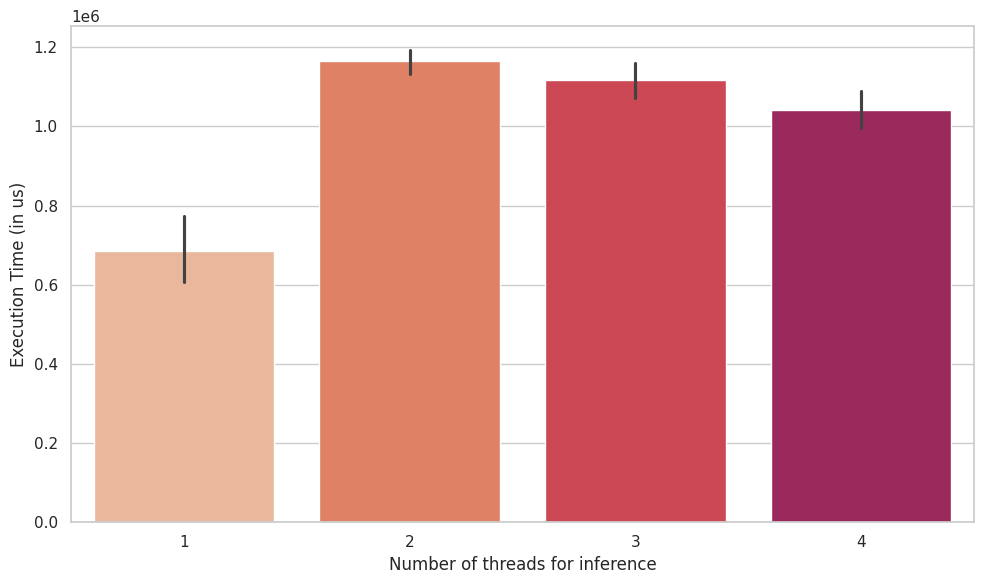

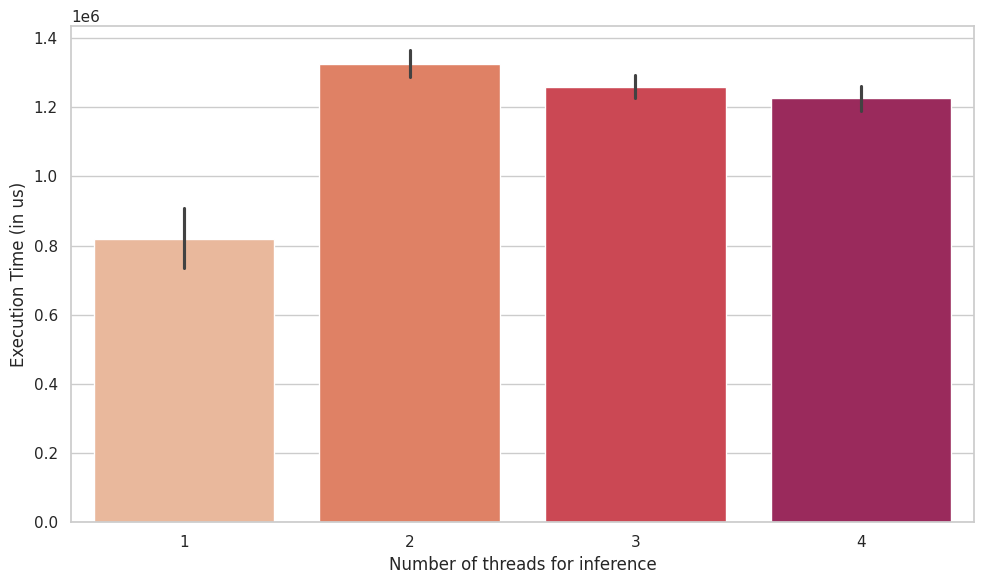

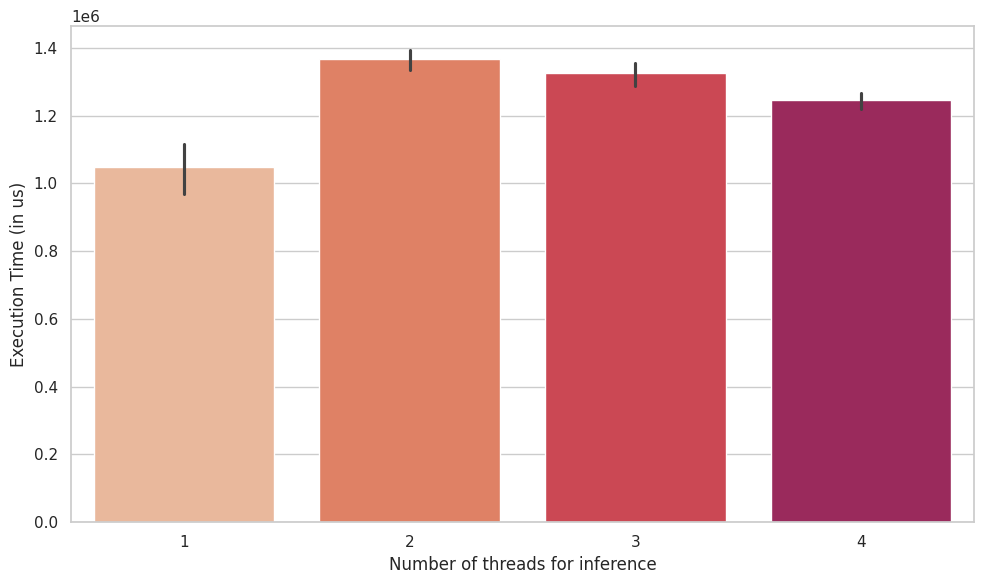

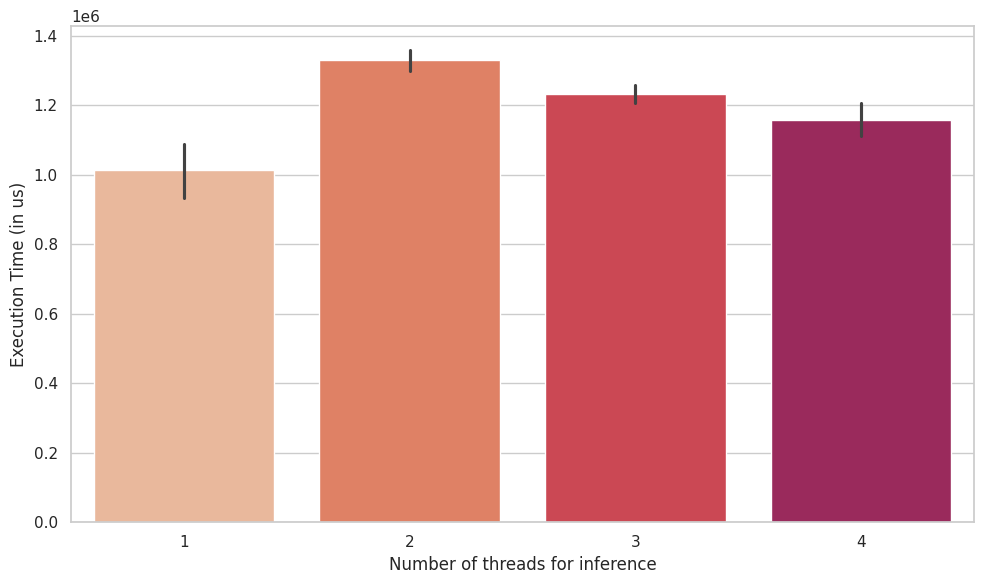

In [148]:
df_exec_time = pd.read_csv(exp_dir + "/execution_time_by_parts.csv")
df_cpu_usage = pd.read_csv(exp_dir + "/cpu_usage.csv")
df_ram_usage = pd.read_csv(exp_dir + "/ram_usage.csv")

for imp in implementations:
    df_exec_time_imp = df_exec_time[df_exec_time["Implementation"] == imp]
    df_exec_time_imp['Subpart'] = df_exec_time_imp['Subpart'].apply(lambda x: textwrap.fill(x, width=20))
    df_cpu_usage_imp = df_cpu_usage[df_cpu_usage["Implementation"] == imp]
    df_ram_usage_imp = df_ram_usage[df_ram_usage["Implementation"] == imp]

    df_exec_time_imp_med = df_exec_time_imp.groupby(["Medium"])

    medium_group = df_exec_time_imp.groupby("Medium")

    colors = sns.color_palette('rocket')[::-1]

    
    # Generate unique colors for each part
    # colors = plt.cm.viridis([i / float(len(part_order)) for i in range(len(part_order))])

    for med, item in medium_group:
        item = item[["Inference Threads", "Part", "Execution Time (in us)"]]
        item = item[item["Part"] == "Real time"]
        # Barplot comparison
        plt.figure(figsize=(10, 6))
        sns.set_style("whitegrid")
        sns.barplot(data=item, x='Inference Threads', y='Execution Time (in us)', palette=colors)

        plt.xlabel("Number of threads for inference")
        plt.ylim(bottom=0)
        plt.tight_layout()
        plt.show
    
        plt.savefig(graphs_exec_time_dir + "/barplot_evolution_threads_" + experiment_name.replace(' ', '_') + "_" + imp + "_" + med + ".pdf")


In [ ]:
df_exec_time = pd.read_csv(exp_dir + "/execution_time_by_parts.csv")
df_cpu_usage = pd.read_csv(exp_dir + "/cpu_usage.csv")
df_ram_usage = pd.read_csv(exp_dir + "/ram_usage.csv")

for imp in implementations:
    df_exec_time_imp = df_exec_time[df_exec_time["Implementation"] == imp]
    df_exec_time_imp = df_exec_time_imp[((df_exec_time_imp["Subpart"] != "Global time") | (df_exec_time_imp["Part"] == "Real time")) & (df_exec_time_imp["Subpart"] != "Run inference") & (df_exec_time_imp["Subpart"] != "Average invokation time per loop")]
    df_exec_time_imp['Subpart'] = df_exec_time_imp['Subpart'].apply(lambda x: textwrap.fill(x, width=20))
    df_cpu_usage_imp = df_cpu_usage[df_cpu_usage["Implementation"] == imp]
    df_ram_usage_imp = df_ram_usage[df_ram_usage["Implementation"] == imp]

    df_exec_time_imp_med = df_exec_time_imp.groupby(["Medium"])

    medium_group = df_exec_time_imp.groupby("Medium")

    colors = sns.color_palette('rocket')[::-1]
    # Generate unique colors for each part
    # colors = plt.cm.viridis([i / float(len(part_order)) for i in range(len(part_order))])

    for med, item in medium_group:
        plt.figure(figsize=(10, 6))
    
        plt.savefig(graphs_exec_time_dir + "/barplot_global_" + experiment_name.replace(' ', '_') + "_" + imp + "_" + med + ".pdf")
